# MRP PROJECT

   Customer churn prediction models have been proven to provide companies the ability to determine if a customer will churn based on a variety of factors. However, this space still has room for improvement and this project aims to determine if a customer churn prediction accuracy can be improved through the use of customer segmentation by cluster groups of customers based on similarities in their buying patterns and company engagement behaviours. Through this process, companies will also gain the ability to better understand which variables lead to a higher churn rate while also being able to use these clusters for ulterior targeted marketing initiatives.

### Importing packages and dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn import metrics

In [2]:
df_train = pd.read_csv('train.csv')
df_train

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,fffe4300490044003600300030003800,Pattie Morrisey,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,...,300.630000,53005.25,17.0,781.750000,Yes,Yes,No,Not Applicable,Products always in Stock,2
1,fffe43004900440032003100300035003700,Traci Peery,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,...,306.340000,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,1
2,fffe4300490044003100390032003600,Merideth Mcmeen,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,...,516.160000,21027.00,22.0,500.690000,No,Yes,Yes,Solved in Follow-up,Poor Website,5
3,fffe43004900440036003000330031003600,Eufemia Cardwell,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,...,53.270000,25239.56,6.0,567.660000,No,Yes,Yes,Unsolved,Poor Website,5
4,fffe43004900440031003900350030003600,Meghan Kosak,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,...,113.130000,24483.66,16.0,663.060000,No,Yes,Yes,Solved,Poor Website,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36987,fffe43004900440035003500390036003100,Cuc Tarr,46,F,6F51HFO,NaN,Basic Membership,2017-09-21,No,xxxxxxxx,...,-650.682759,27277.68,6.0,639.510000,No,Yes,Yes,No Information Available,No reason specified,4
36988,fffe43004900440033003500380036003600,Jenni Stronach,29,F,21KSM8Y,Town,Basic Membership,2016-06-27,No,xxxxxxxx,...,-638.123421,11069.71,28.0,527.990000,Yes,No,No,Not Applicable,Poor Customer Service,5
36989,fffe4300490044003500330034003100,Luciana Kinch,23,F,XK1IM9H,NaN,Basic Membership,2016-09-11,Yes,CID3838,...,154.940000,38127.56,Error,680.470000,No,Yes,Yes,Unsolved,Poor Website,4
36990,fffe43004900440031003200390039003000,Tawana Ardoin,53,M,K6VTP1Z,Village,Platinum Membership,2017-06-15,No,xxxxxxxx,...,482.610000,2378.86,20.0,197.264414,Yes,Yes,No,Not Applicable,No reason specified,3


In [3]:
df_test = pd.read_csv('test.csv')
df_test

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback
0,fffe43004900440031003700300030003400,Alethia Meints,50,F,OQJ1XAY,Village,Premium Membership,2015-11-02,No,xxxxxxxx,...,12,386.26,40721.44,7.0,733.830000,Yes,No,No,Not Applicable,Poor Product Quality
1,fffe43004900440031003900370037003300,Ming Lopez,41,M,OUQRPKO,Village,Gold Membership,2016-03-01,No,xxxxxxxx,...,11,37.80,9644.40,9.0,726.000000,Yes,No,No,Not Applicable,Poor Website
2,fffe43004900440034003800360037003000,Carina Flannigan,31,F,02J2RE7,Town,Silver Membership,2017-03-03,No,xxxxxxxx,...,18,215.36,3693.25,21.0,713.780000,Yes,No,Yes,Solved in Follow-up,No reason specified
3,fffe43004900440036003200370033003400,Kyung Wanner,64,M,5YEQIF1,Town,Silver Membership,2017-08-18,Yes,CID8941,...,-999,44.57,36809.56,11.0,744.970000,Yes,No,Yes,No Information Available,Too many ads
4,fffe43004900440035003000370031003900,Enola Gatto,16,F,100RYB5,Town,No Membership,2015-05-05,Yes,CID5690,...,6,349.88,40675.86,8.0,299.048351,No,Yes,Yes,Solved in Follow-up,Poor Website
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19914,fffe43004900440035003600330037003800,Kraig Peele,12,M,2V0HA0O,NaN,Gold Membership,2015-01-25,No,xxxxxxxx,...,16,103.57,46279.35,18.0,708.120000,No,Yes,No,Not Applicable,Poor Product Quality
19915,fffe43004900440032003900370037003100,Damaris Sabol,40,F,VJGQD6Q,Village,No Membership,2017-12-31,Yes,CID45490,...,21,63.19,23466.26,Error,574.340000,No,Yes,No,Not Applicable,No reason specified
19916,fffe43004900440036003100310036003700,Loura Huckstep,55,M,ADE7LWA,Town,No Membership,2015-09-09,No,xxxxxxxx,...,18,68.72,17903.75,24.0,564.300000,No,Yes,Yes,Unsolved,No reason specified
19917,fffe43004900440034003200330033003600,Sharita Clubb,17,F,A35KUBS,City,Silver Membership,2016-04-17,Yes,CID37167,...,3,119.54,14057.09,22.0,606.340000,No,Yes,No,Not Applicable,Poor Website


In [4]:
targetFeature = 'churn_risk_score'

### EDA

In [ ]:
fig, ax = plt.subplots(figsize = (15,8))
sns.color_palette("Spectral", as_cmap=True)
sns.set_style('white')
sns.countplot(data=final_df_train.sort_values(by='feedback'), x='feedback', hue='churn_risk_score', palette = 'Spectral_r')
plt.xlabel('Feedback', labelpad = 15,  fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Total Feedback', labelpad = 15, fontsize=14)
plt.title('Count of Feedback Type based on Churn Risk Score', y = 1.02,  fontsize=18, fontweight = 'bold')

In [ ]:
fig, ax = plt.subplots(figsize = (15,8))
sns.color_palette("Spectral", as_cmap=True)
sns.set_style('white')
sns.countplot(data=final_df_train.sort_values(by='churn_risk_score'), x='churn_risk_score', hue='gender',palette=['#f699cd',"#6495ED"])
plt.xlabel('Churn Risk Score', labelpad = 15,  fontsize=14);
plt.ylabel('Total Count ', labelpad = 15, fontsize=14);
plt.title('Count of Gender based on Churn Risk Score', y = 1.02,  fontsize=18, fontweight = 'bold')

In [ ]:
fig, ax = plt.subplots(figsize = (15,8))
sns.color_palette("Spectral", as_cmap=True)
sns.set_style('white')
sns.countplot(data=final_df_train.sort_values(by='membership_category'), x='membership_category', hue='churn_risk_score', palette='Spectral_r')
plt.xlabel('Membership Type', labelpad = 15,  fontsize=14);
plt.ylabel('Total Count of Memberships', labelpad = 15, fontsize=14);
plt.title('Count of Membership Type based on Churn Risk Score', y = 1.02,  fontsize=18, fontweight = 'bold')

In [ ]:
fig, ax = plt.subplots(figsize = (15,8))
sns.set_style('white')
sns.heatmap(df_train.corr(), vmax=1, vmin=-1, annot=True, cmap='vlag')
plt.title('Correlation Plot for Numerical Variables', y = 1.02,  fontsize=18, fontweight = 'bold')

### Data Cleaning

In [5]:
print(df_train.dtypes)

customer_id                      object
Name                             object
age                               int64
gender                           object
security_no                      object
region_category                  object
membership_category              object
joining_date                     object
joined_through_referral          object
referral_id                      object
preferred_offer_types            object
medium_of_operation              object
internet_option                  object
last_visit_time                  object
days_since_last_login             int64
avg_time_spent                  float64
avg_transaction_value           float64
avg_frequency_login_days         object
points_in_wallet                float64
used_special_discount            object
offer_application_preference     object
past_complaint                   object
complaint_status                 object
feedback                         object
churn_risk_score                  int64


In [6]:
df_train['gender'] = df_train['gender'].replace('Unknown',np.NaN) # replace Unknown with NaN for further imputing
df_train['joined_through_referral'] = df_train['joined_through_referral'].replace('?',np.NaN) # replace ? with NaN for further imputing
df_train['referral_id'] = df_train['referral_id'].replace('xxxxxxxx',np.NaN)  # replace xxxxx with NaN for further imputing
df_train['medium_of_operation'] = df_train['medium_of_operation'].replace('?',np.NaN) # replace ? with NaN for further imputing
df_train['days_since_last_login'] = df_train['days_since_last_login'].replace(-999,np.NaN)  # replace -999 with NaN for further imputing
df_train.loc[~(df_train['avg_time_spent'] > 0), 'avg_time_spent']=np.nan # replace all negative values with NaN for further imputing
df_train.loc[~(df_train['points_in_wallet'] > 0), 'points_in_wallet']=np.nan # replace all negative values with NaN for further imputing

df_train['avg_frequency_login_days'] = df_train['avg_frequency_login_days'].replace('Error',np.NaN) # replace Error with NaN for further imputing
df_train['avg_frequency_login_days']=df_train['avg_frequency_login_days'].astype('float')
df_train.loc[~(df_train['avg_frequency_login_days'] > 0), 'avg_frequency_login_days']=np.nan # replace all negative values with NaN for further imputing

In [7]:
## based on research, mode is best for imputing for categorical variables with a small number of unique values, which 
## is the case in this dataset, as is with most categorical variables
cat_var_imputing = df_train[['gender','region_category','joined_through_referral','preferred_offer_types','medium_of_operation',]]
for i, variable in enumerate(cat_var_imputing):
    df_train[variable].fillna(df_train[variable].mode()[0], inplace=True)

In [8]:
## based on research, for numerical variables, KNN imputing is preferred:
### In this approach, we specify a distance from the missing values which is also known as the K parameter. 
## The missing value will be predicted in reference to the mean of the neighbours. It is implemented by the KNNimputer() method

num_imputing = df_train[['points_in_wallet','avg_time_spent','days_since_last_login','avg_frequency_login_days']]
imp = KNNImputer(n_neighbors=2)
imputed_vals=imp.fit_transform(num_imputing)

temp_dataset = pd.DataFrame({
    'points_in_wallet':imputed_vals.T[0],
    'avg_time_spent':imputed_vals.T[1],
    'days_since_last_login':imputed_vals.T[2],
    'avg_frequency_login_days':imputed_vals.T[3]

})

df_train.drop(['points_in_wallet','avg_time_spent','days_since_last_login','avg_frequency_login_days'], axis=1, inplace=True)

final_df_train = pd.concat([df_train, temp_dataset], axis=1)

In [9]:
final_df_train.isnull().sum()

customer_id                         0
Name                                0
age                                 0
gender                              0
security_no                         0
region_category                     0
membership_category                 0
joining_date                        0
joined_through_referral             0
referral_id                     17846
preferred_offer_types               0
medium_of_operation                 0
internet_option                     0
last_visit_time                     0
avg_transaction_value               0
used_special_discount               0
offer_application_preference        0
past_complaint                      0
complaint_status                    0
feedback                            0
churn_risk_score                    0
points_in_wallet                    0
avg_time_spent                      0
days_since_last_login               0
avg_frequency_login_days            0
dtype: int64

In [10]:
df_test.isnull().sum()

customer_id                        0
Name                               0
age                                0
gender                             0
security_no                        0
region_category                 2948
membership_category                0
joining_date                       0
joined_through_referral            0
referral_id                        0
preferred_offer_types            159
medium_of_operation                0
internet_option                    0
last_visit_time                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days           0
points_in_wallet                1963
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
dtype: int64

In [11]:
df_test['gender'] = df_test['gender'].replace('Unknown',np.NaN) # replace Unknown with NaN for further imputing
df_test['joined_through_referral'] = df_test['joined_through_referral'].replace('?',np.NaN) # replace ? with NaN for further imputing
df_test['referral_id'] = df_test['referral_id'].replace('xxxxxxxx',np.NaN)  # replace xxxxx with NaN for further imputing
df_test['medium_of_operation'] = df_test['medium_of_operation'].replace('?',np.NaN) # replace ? with NaN for further imputing
df_test['days_since_last_login'] = df_test['days_since_last_login'].replace(-999,np.NaN)  # replace -999 with NaN for further imputing
df_test.loc[~(df_test['avg_time_spent'] > 0), 'avg_time_spent']=np.nan # replace all negative values with NaN for further imputing
df_test.loc[~(df_test['points_in_wallet'] > 0), 'points_in_wallet']=np.nan # replace all negative values with NaN for further imputing

df_test['avg_frequency_login_days'] = df_test['avg_frequency_login_days'].replace('Error',np.NaN) # replace Error with NaN for further imputing
df_test['avg_frequency_login_days']=df_test['avg_frequency_login_days'].astype('float')
df_test.loc[~(df_test['avg_frequency_login_days'] > 0), 'avg_frequency_login_days']=np.nan # replace all negative values with NaN for further imputing

In [12]:
## based on research, mode is best for imputing for categorical variables with a small number of unique values, which 
## is the case in this dataset, as is with most categorical variables
cat_var_imputing = df_test[['gender','region_category','joined_through_referral','preferred_offer_types','medium_of_operation',]]
for i, variable in enumerate(cat_var_imputing):
    df_test[variable].fillna(df_test[variable].mode()[0], inplace=True)

In [13]:
## based on research, for numerical variables, KNN imputing is preferred:
### In this approach, we specify a distance from the missing values which is also known as the K parameter. 
## The missing value will be predicted in reference to the mean of the neighbours. It is implemented by the KNNimputer() method

num_imputing_test = df_test[['points_in_wallet','avg_time_spent','days_since_last_login','avg_frequency_login_days']]
imp_test = KNNImputer(n_neighbors=2)
imputed_vals_test=imp_test.fit_transform(num_imputing_test)

temp_dataset2 = pd.DataFrame({
    'points_in_wallet':imputed_vals_test.T[0],
    'avg_time_spent':imputed_vals_test.T[1],
    'days_since_last_login':imputed_vals_test.T[2],
    'avg_frequency_login_days':imputed_vals_test.T[3]

})

df_test.drop(['points_in_wallet','avg_time_spent','days_since_last_login','avg_frequency_login_days'], axis=1, inplace=True)

final_df_test = pd.concat([df_test, temp_dataset2], axis=1)

In [14]:
final_df_test.isnull().sum()

customer_id                        0
Name                               0
age                                0
gender                             0
security_no                        0
region_category                    0
membership_category                0
joining_date                       0
joined_through_referral            0
referral_id                     9454
preferred_offer_types              0
medium_of_operation                0
internet_option                    0
last_visit_time                    0
avg_transaction_value              0
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
points_in_wallet                   0
avg_time_spent                     0
days_since_last_login              0
avg_frequency_login_days           0
dtype: int64

In [15]:
#final_df_train['days_since_last_login'] = final_df_train['days_since_last_login'].astype('int64')
final_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   36992 non-null  object 
 1   Name                          36992 non-null  object 
 2   age                           36992 non-null  int64  
 3   gender                        36992 non-null  object 
 4   security_no                   36992 non-null  object 
 5   region_category               36992 non-null  object 
 6   membership_category           36992 non-null  object 
 7   joining_date                  36992 non-null  object 
 8   joined_through_referral       36992 non-null  object 
 9   referral_id                   19146 non-null  object 
 10  preferred_offer_types         36992 non-null  object 
 11  medium_of_operation           36992 non-null  object 
 12  internet_option               36992 non-null  object 
 13  l

In [16]:
final_df_test['days_since_last_login'] = final_df_test['days_since_last_login'].astype('int64')
final_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19919 entries, 0 to 19918
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   19919 non-null  object 
 1   Name                          19919 non-null  object 
 2   age                           19919 non-null  int64  
 3   gender                        19919 non-null  object 
 4   security_no                   19919 non-null  object 
 5   region_category               19919 non-null  object 
 6   membership_category           19919 non-null  object 
 7   joining_date                  19919 non-null  object 
 8   joined_through_referral       19919 non-null  object 
 9   referral_id                   10465 non-null  object 
 10  preferred_offer_types         19919 non-null  object 
 11  medium_of_operation           19919 non-null  object 
 12  internet_option               19919 non-null  object 
 13  l

In [17]:
# getting rid of negative churn risk
negative_churn = np.where(final_df_train['churn_risk_score'] == -1)
final_df_train.drop(negative_churn[0],inplace=True)
final_df_train.index = range(0,final_df_train.shape[0])

In [18]:
# adding year variable to training and testing df
final_df_train['year']=final_df_train.joining_date.apply(lambda k:2021-int(k.split('-')[0]))
final_df_test['year']=final_df_test.joining_date.apply(lambda k:2021-int(k.split('-')[0]))

### Outlier Detection

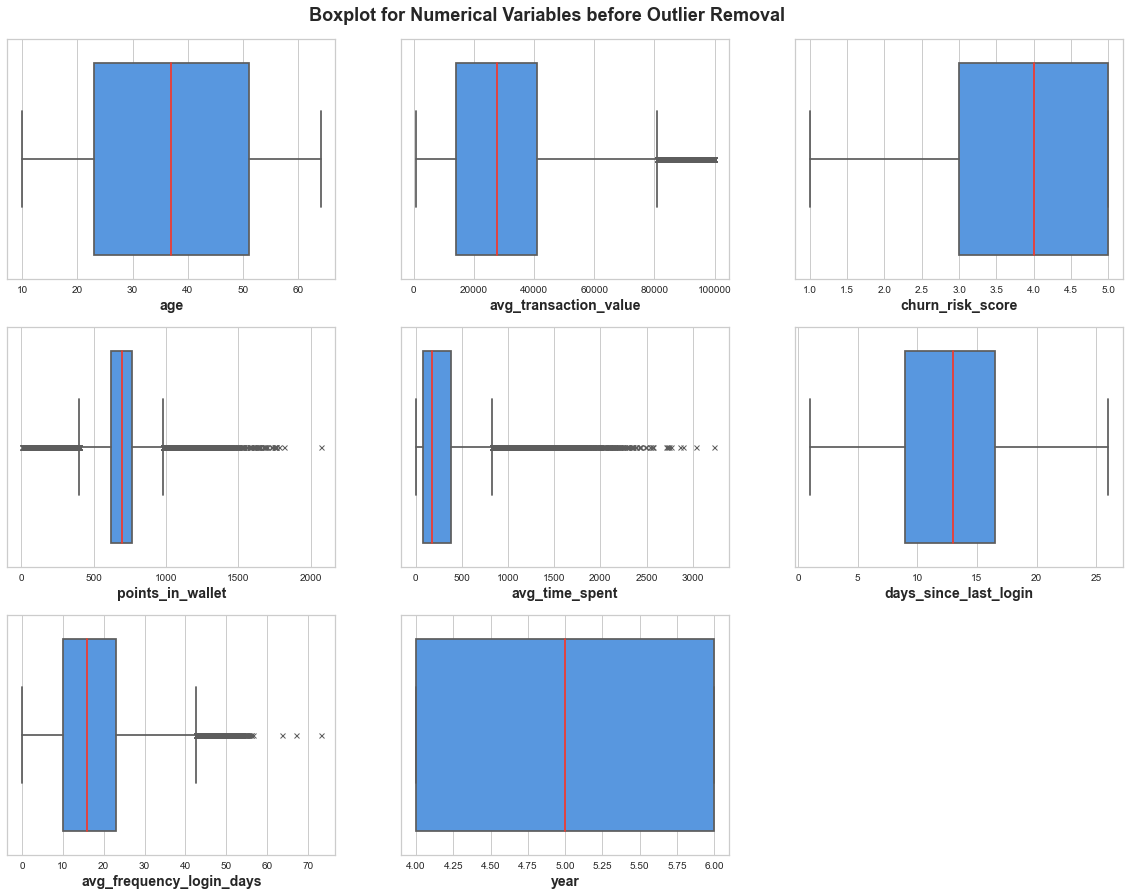

In [19]:
final_df_outliers=final_df_train.select_dtypes(include=[np.number])

fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(20, 15)) 
for variable, subplot in zip(final_df_outliers.columns, ax.flatten()):
    z = sns.boxplot(x = final_df_outliers[variable], orient = "h" , ax=subplot, flierprops={"marker": "x"}, 
                    medianprops={"color": "#f03a2e"}, dodge=False, palette = ['#4296f5'])
    z.set_xlabel(variable, fontsize = 14, fontweight = 'bold')
fig.delaxes(ax[2][2])
fig.suptitle('Boxplot for Numerical Variables before Outlier Removal', y = 0.91,  fontsize=18, fontweight = 'bold')
plt.show()

From the above, it can be seen that avg_transaction_value, points_in_wallet, avg_time_spent and avg_frequency_login_days all have outliers.

In [20]:
Q1 = final_df_train.quantile(0.25) 
Q3 = final_df_train.quantile(0.75) 
IQR = Q3 - Q1 

In [21]:
final_data_train_iqr = final_df_train[~((final_df_train < (Q1 - 1.5 * IQR)) |(final_df_train > (Q3 + 1.5 * IQR))).any(axis=1)] 
final_data_train_iqr.reset_index(inplace=True)
final_data_train_iqr.drop('index',axis=1, inplace=True)
final_data_train_iqr

/var/folders/1y/cgchrjwd7wlflct28tbjgcgw0000gn/T/ipykernel_54340/3742087493.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  final_data_train_iqr = final_df_train[~((final_df_train < (Q1 - 1.5 * IQR)) |(final_df_train > (Q3 + 1.5 * IQR))).any(axis=1)]
/var/folders/1y/cgchrjwd7wlflct28tbjgcgw0000gn/T/ipykernel_54340/3742087493.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data_train_iqr.drop('index',axis=1, inplace=True)


,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score,points_in_wallet,avg_time_spent,days_since_last_login,avg_frequency_login_days,year
0,fffe4300490044003600300030003800,Pattie Morrisey,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,NaN,...,Yes,No,Not Applicable,Products always in Stock,2,781.750000,300.630,17.0,17.0,4
1,fffe43004900440032003100300035003700,Traci Peery,32,F,5K0N3X1,City,Premium Membership,2017-08-28,No,CID21329,...,No,Yes,Solved,Quality Customer Care,1,498.382015,306.340,16.0,10.0,4
2,fffe4300490044003100390032003600,Merideth Mcmeen,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,...,Yes,Yes,Solved in Follow-up,Poor Website,5,500.690000,516.160,14.0,22.0,5
3,fffe43004900440036003000330031003600,Eufemia Cardwell,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,...,Yes,Yes,Unsolved,Poor Website,5,567.660000,53.270,11.0,6.0,5
4,fffe43004900440031003900350030003600,Meghan Kosak,31,F,SVZXCWB,City,No Membership,2017-09-12,No,NaN,...,Yes,Yes,Solved,Poor Website,5,663.060000,113.130,20.0,16.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27718,fffe43004900440034003900300036003500,Marlena Chastain,27,M,8X0LUUS,Town,Platinum Membership,2015-09-07,Yes,CID15800,...,No,No,Not Applicable,No reason specified,3,748.570000,135.830,13.0,16.0,6
27719,fffe43004900440035003500390036003100,Cuc Tarr,46,F,6F51HFO,Town,Basic Membership,2017-09-21,No,NaN,...,Yes,Yes,No Information Available,No reason specified,4,639.510000,638.795,2.0,6.0,4
27720,fffe43004900440033003500380036003600,Jenni Stronach,29,F,21KSM8Y,Town,Basic Membership,2016-06-27,No,NaN,...,No,No,Not Applicable,Poor Customer Service,5,527.990000,140.965,13.0,28.0,5
27721,fffe4300490044003500330034003100,Luciana Kinch,23,F,XK1IM9H,Town,Basic Membership,2016-09-11,Yes,CID3838,...,Yes,Yes,Unsolved,Poor Website,4,680.470000,154.940,12.0,6.5,5


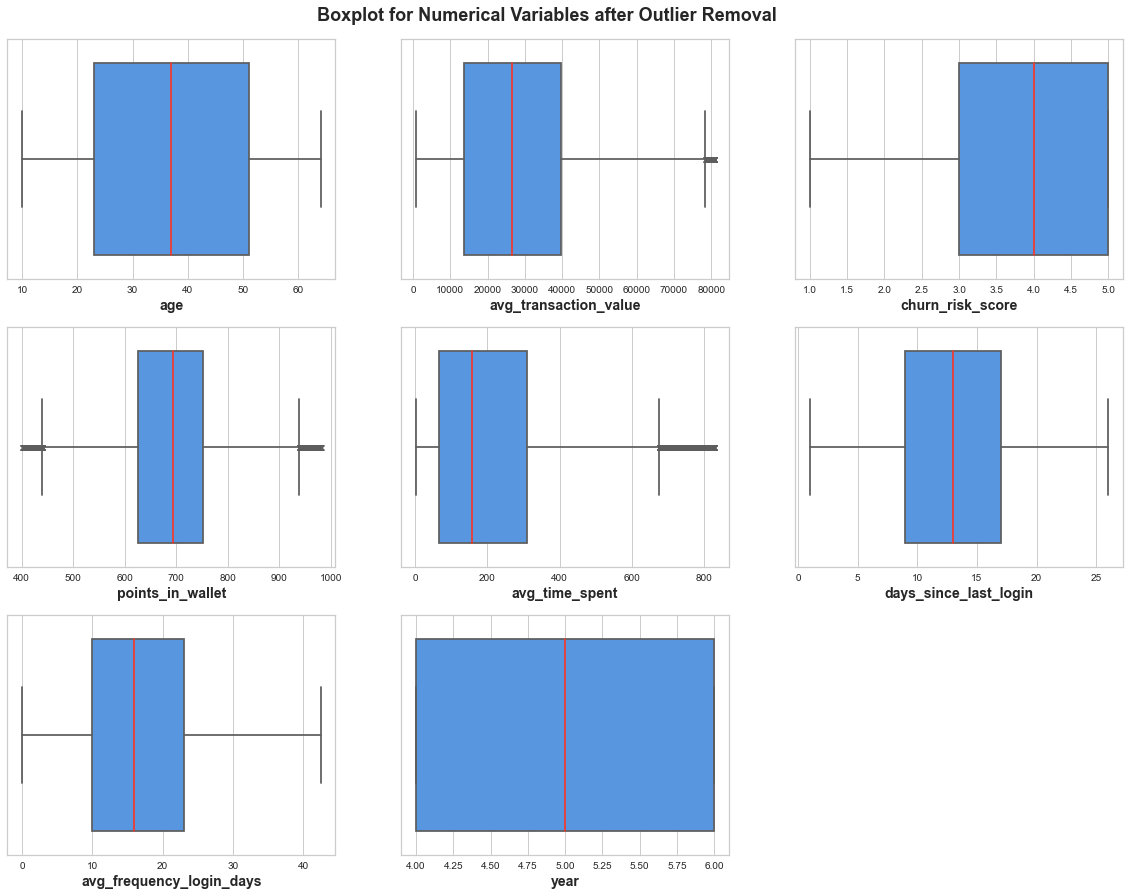

In [22]:
## AFTER REMOVING OUTLIERS:
final_df_outliers2=final_data_train_iqr.select_dtypes(include=[np.number])

fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(20, 15)) 
for variable, subplot in zip(final_df_outliers2.columns, ax.flatten()):
    z = sns.boxplot(x = final_df_outliers2[variable], orient = "h", ax=subplot, flierprops={"marker": "x"}, 
                medianprops={"color": "#f03a2e"}, dodge=False, palette = ['#4296f5']) 
    z.set_xlabel(variable, fontsize = 14, fontweight = 'bold')
fig.delaxes(ax[2][2])
fig.suptitle('Boxplot for Numerical Variables after Outlier Removal', y = 0.91,  fontsize=18, fontweight = 'bold')
plt.show()

### Categorical Encoding and Balancing Dataset

In [23]:
final_df_train['churn_risk_score'].value_counts()

3    10424
4    10185
5     9827
2     2741
1     2652
Name: churn_risk_score, dtype: int64

In [24]:
cats = ['gender','region_category','membership_category','joined_through_referral',
      'preferred_offer_types','medium_of_operation','internet_option','used_special_discount',
       'offer_application_preference','past_complaint','complaint_status','feedback']
df_train_balanced = final_df_train[cats]
df_test_balanced = final_df_test[cats]

In [25]:
# categorical encoding of newly created test and training dataset
df_train_balanced = pd.get_dummies(df_train_balanced)
df_test_balanced = pd.get_dummies(df_test_balanced)

In [26]:
nums_train = ['days_since_last_login','avg_time_spent','avg_transaction_value','avg_frequency_login_days',
'points_in_wallet','used_special_discount','churn_risk_score']
df_train_balanced_num = final_df_train[nums_train]
nums_test = ['days_since_last_login','avg_time_spent','avg_transaction_value','avg_frequency_login_days',
'points_in_wallet','used_special_discount']
df_test_balanced_num = final_df_test[nums_test]

In [27]:
final_df_train = pd.concat([df_train_balanced_num,df_train_balanced],axis=1)
final_df_test = pd.concat([df_test_balanced_num,df_test_balanced],axis=1)
final_df_train.drop('used_special_discount',axis=1,inplace=True)
final_df_test.drop('used_special_discount',axis=1,inplace=True)

In [28]:
X = final_df_train.drop(['churn_risk_score'],axis=1).values
Y = final_df_train['churn_risk_score'].values

# Applying SMOTE Over Sampling Strategy for balancing dataset
oversample = SMOTE()
X_ov,Y_ov = oversample.fit_resample(X,Y)
print('The dataset before oversampling: ',X.shape,Y.shape)
print('The dataset after oversampling: ',X_ov.shape,Y_ov.shape)

The dataset before oversampling:  (35829, 47) (35829,)
The dataset after oversampling:  (52120, 47) (52120,)


In [29]:
scaler = RobustScaler()
X_ov = scaler.fit_transform(X_ov)
X_test = final_df_test.values
X_test = scaler.transform(X_test)

### Feature Importance and Identifying Parameters

In [30]:
Features = final_df_train.drop(['churn_risk_score'] ,axis = 1)
Target = final_df_train['churn_risk_score']

In [31]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(Features, Target, test_size=0.20, random_state=42)
model =  RandomForestClassifier(random_state = 0)
model.fit(X_train1, y_train1)

RandomForestClassifier(random_state=0)

In [32]:
important_features = pd.DataFrame({'Features': X_train1.columns, 'Importance': model.feature_importances_})
selected_features = important_features.loc[(important_features["Importance"] >= 0.01)]
important_features = selected_features.sort_values('Importance', ascending = False)

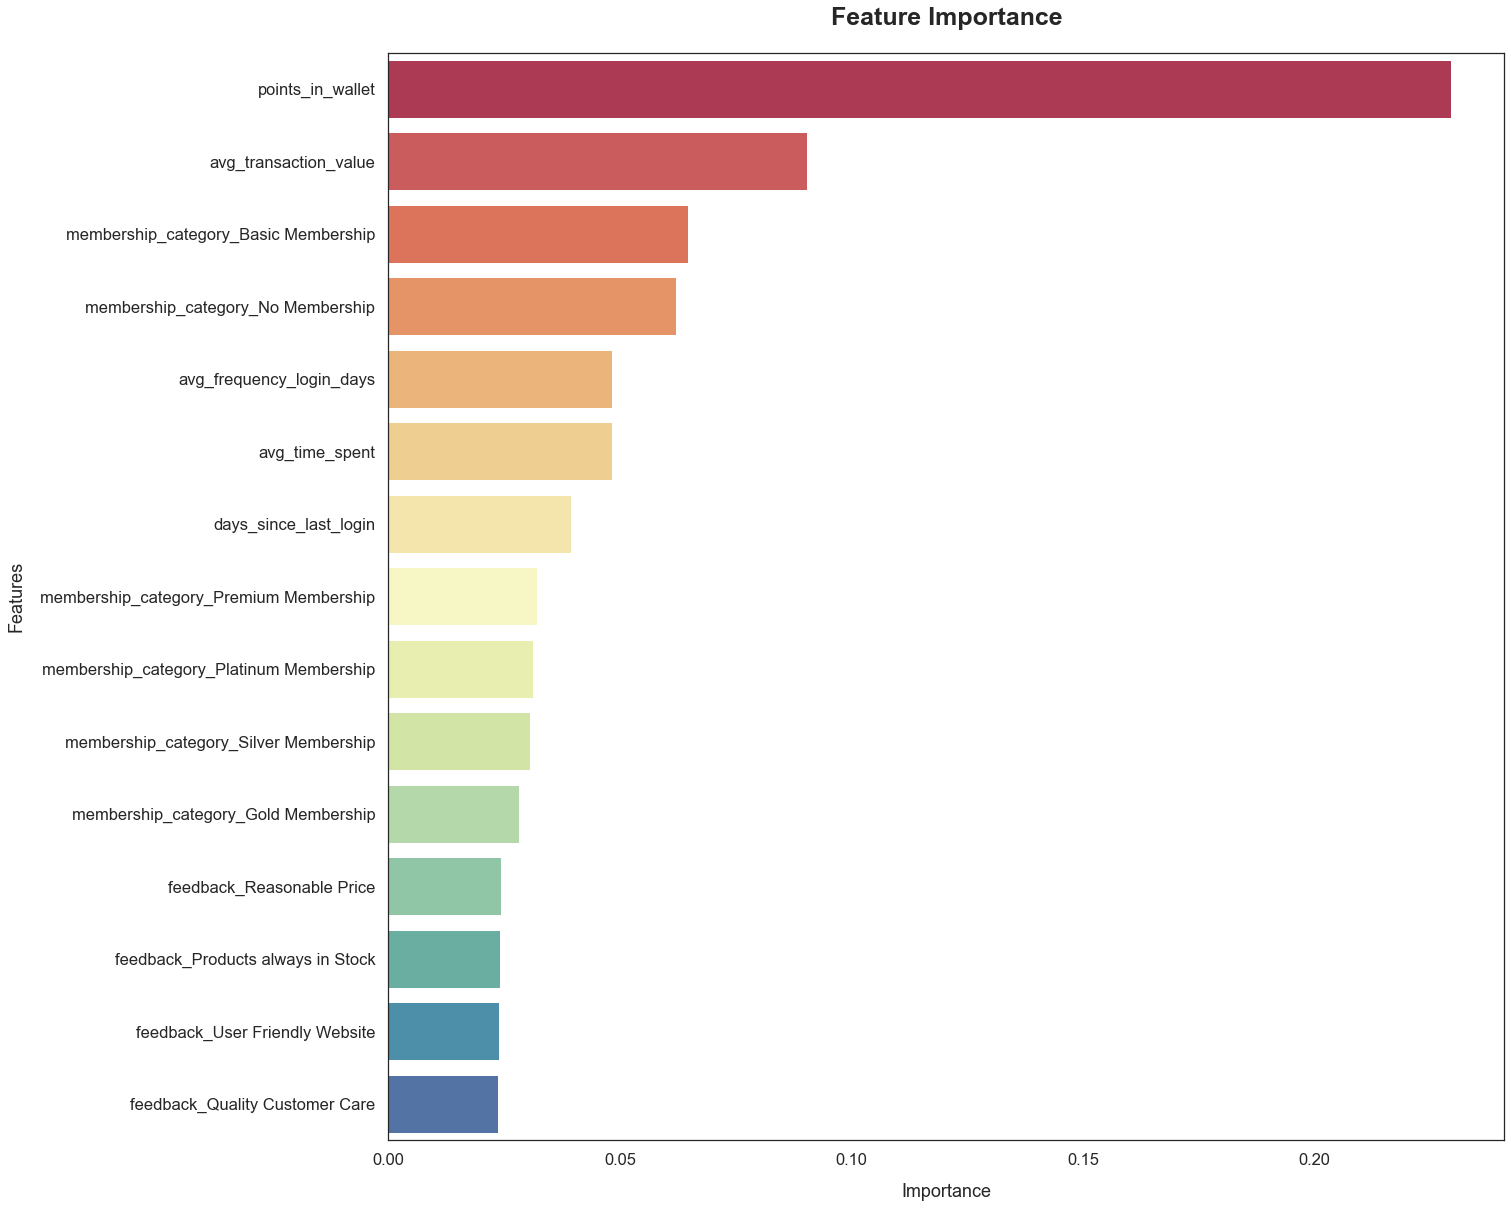

In [33]:
plt.rcParams["figure.figsize"] = (20,20)
sns.set(font_scale=1.5)
sns.set_style('white')
sns.barplot(x = 'Importance', y = 'Features', data = important_features, palette = 'Spectral' )
plt.title('Feature Importance', y = 1.02,  fontsize=25, fontweight = 'bold')
plt.xlabel('Importance', labelpad = 15, fontsize = 18)
plt.ylabel('Features', labelpad = 15, fontsize = 18)

plt.show()

### Data Modeling

In [237]:
x_train,x_test,y_train,y_test = train_test_split(X_ov,Y_ov,train_size=0.7)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(36484, 47) (36484,)
(15636, 47) (15636,)


In [238]:
## RANDOM FOREST CLASSIFIER

rf = RandomForestClassifier(n_estimators=1000,max_depth=25)
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)
print(classification_report(y_true=y_test,y_pred=y_pred))
print(f1_score(y_true=y_test,y_pred=y_pred,average='macro'))

              precision    recall  f1-score   support

           1       0.87      0.92      0.89      3088
           2       0.91      0.86      0.89      3128
           3       0.88      0.94      0.91      3118
           4       0.76      0.51      0.61      3093
           5       0.73      0.91      0.81      3209

    accuracy                           0.83     15636
   macro avg       0.83      0.83      0.82     15636
weighted avg       0.83      0.83      0.82     15636

0.8207472603507586


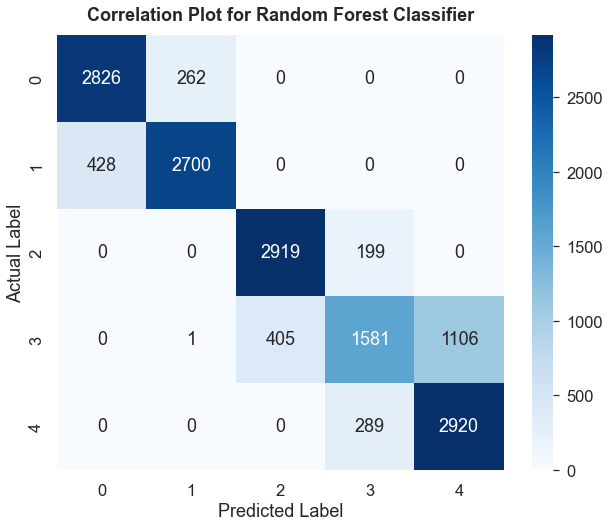

In [239]:
fig, ax = plt.subplots(figsize = (10,8))
sns.set_style('white')
cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
sns.heatmap(cm, annot=True, ax = ax, cmap = 'Blues', fmt = 'g')
plt.title('Correlation Plot for Random Forest Classifier', y = 1.02,  fontsize=18, fontweight = 'bold')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
plt.show()

In [240]:
## MLP Classifier with 3 hidden layers of decreasing nodes

mlp = MLPClassifier(hidden_layer_sizes=(120,95,70))
mlp.fit(x_train,y_train)
y_pred = mlp.predict(x_test)
print(classification_report(y_true=y_test,y_pred=y_pred))
print(f1_score(y_true=y_test,y_pred=y_pred,average='macro'))

              precision    recall  f1-score   support

           1       0.90      0.89      0.89      3088
           2       0.89      0.91      0.90      3128
           3       0.89      0.89      0.89      3118
           4       0.64      0.59      0.61      3093
           5       0.73      0.79      0.76      3209

    accuracy                           0.81     15636
   macro avg       0.81      0.81      0.81     15636
weighted avg       0.81      0.81      0.81     15636

0.8104740543229305


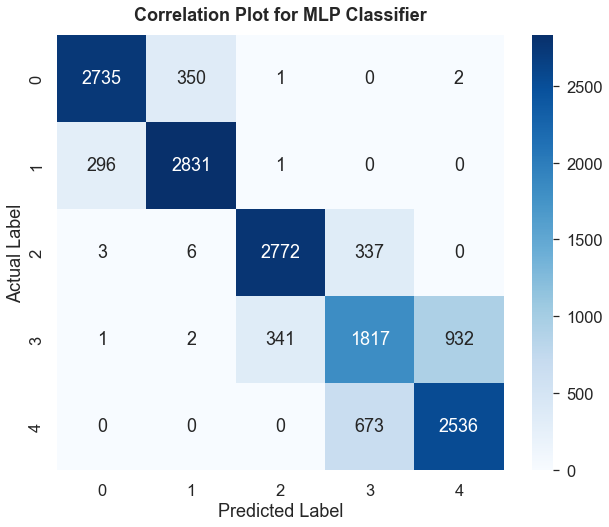

In [241]:
fig, ax = plt.subplots(figsize = (10,8))
sns.set_style('white')
cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
sns.heatmap(cm, annot=True, ax = ax, cmap = 'Blues',fmt = 'g')
plt.title('Correlation Plot for MLP Classifier', y = 1.02,  fontsize=18, fontweight = 'bold')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
plt.show()

In [243]:
## Gradient Boosting Classifier

gb = GradientBoostingClassifier(n_estimators=1000,max_depth=25,min_samples_leaf = 4, min_samples_split= 5)
gb.fit(x_train,y_train)
y_pred = gb.predict(x_test)
print(classification_report(y_true=y_test,y_pred=y_pred))
print(f1_score(y_true=y_test,y_pred=y_pred,average='macro'))

              precision    recall  f1-score   support

           1       0.89      0.92      0.91      3088
           2       0.92      0.89      0.90      3128
           3       0.92      0.91      0.91      3118
           4       0.69      0.62      0.65      3093
           5       0.74      0.83      0.78      3209

    accuracy                           0.83     15636
   macro avg       0.83      0.83      0.83     15636
weighted avg       0.83      0.83      0.83     15636

0.8313885307278335


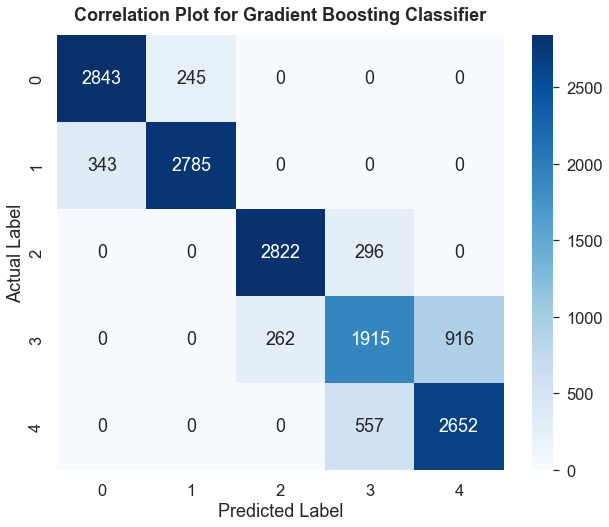

In [244]:
fig, ax = plt.subplots(figsize = (10,8))
sns.set_style('white')
cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
sns.heatmap(cm, annot=True, ax = ax, cmap = 'Blues', fmt = 'g')
plt.title('Correlation Plot for Gradient Boosting Classifier', y = 1.02,  fontsize=18, fontweight = 'bold')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
plt.show()

### Model Performance

In [245]:
# Training
y_pred2tr = rf.predict(x_train)
y_pred3tr = mlp.predict(x_train)
y_pred4tr = gb.predict(x_train)

# Testing
y_pred2 = rf.predict(x_test)
y_pred3 = mlp.predict(x_test)
y_pred4 = gb.predict(x_test)


In [246]:
def accuracy(y_test , ypred):
    auc = accuracy_score(y_test , ypred)
    return auc

def f1(y_test , ypred):
    f = f1_score(y_test, ypred, average='macro')
    return f

In [247]:
# Final Comparison Table
results = pd.DataFrame({'Prediction Model':['Random Forest','MLP','Gradient Boosting'],
                    'Training Accuracy (%)':[accuracy(y_train,y_pred2tr), accuracy(y_train,y_pred3tr), accuracy(y_train,y_pred4tr)],
                    'Testing Accuracy (%)':[accuracy(y_test,y_pred2), accuracy(y_test,y_pred3), accuracy(y_test,y_pred4)],
                    'Testing f1-score (%)':[f1(y_test,y_pred2), f1(y_test,y_pred3), f1(y_test,y_pred4)]})
results.style.highlight_max(color = 'lightgreen', subset = 'Testing Accuracy (%)')

,Prediction Model,Training Accuracy (%),Testing Accuracy (%),Testing f1-score (%)
0,Random Forest,1.000000,0.827961,0.820747
1,MLP,0.986569,0.811653,0.810474
2,Gradient Boosting,1.000000,0.832502,0.831389


## --- Churn Prediction with Segmentation Method # 1 -  K Means --- 

In [34]:
# Use standard scaler to scale and standardize variables

col_names = ['days_since_last_login', 'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days',
            'points_in_wallet', 'churn_risk_score', 'gender_F', 'gender_M', 'region_category_City',
            'region_category_Town', 'region_category_Village', 'membership_category_Basic Membership',
            'membership_category_Gold Membership', 'membership_category_No Membership', 'membership_category_Platinum Membership',
            'membership_category_Premium Membership', 'membership_category_Silver Membership', 'joined_through_referral_No',
            'joined_through_referral_Yes', 'preferred_offer_types_Credit/Debit Card Offers',
            'preferred_offer_types_Gift Vouchers/Coupons', 'preferred_offer_types_Without Offers',
            'medium_of_operation_Both', 'medium_of_operation_Desktop', 'medium_of_operation_Smartphone',
            'internet_option_Fiber_Optic', 'internet_option_Mobile_Data', 'internet_option_Wi-Fi', 'used_special_discount_No',
            'used_special_discount_Yes', 'offer_application_preference_No', 'offer_application_preference_Yes',
            'past_complaint_No', 'past_complaint_Yes', 'complaint_status_No Information Available',
            'complaint_status_Not Applicable', 'complaint_status_Solved', 'complaint_status_Solved in Follow-up',
            'complaint_status_Unsolved', 'feedback_No reason specified', 'feedback_Poor Customer Service',
            'feedback_Poor Product Quality', 'feedback_Poor Website', 'feedback_Products always in Stock',
            'feedback_Quality Customer Care', 'feedback_Quality Customer Care', 'feedback_Reasonable Price',
            'feedback_Too many ads', 'feedback_User Friendly Website']
sd=StandardScaler()
features = final_df_train[col_names]
scaler = sd.fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)
scaled_features.head()

,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score,gender_F,gender_M,region_category_City,region_category_Town,...,feedback_No reason specified,feedback_Poor Customer Service,feedback_Poor Product Quality,feedback_Poor Website,feedback_Products always in Stock,feedback_Quality Customer Care,feedback_Quality Customer Care,feedback_Reasonable Price,feedback_Too many ads,feedback_User Friendly Website
0,0.780746,0.019971,1.216415,0.057028,0.502653,-1.367107,0.998132,-0.998132,-0.723692,-1.060464,...,-0.451722,-0.451005,-0.455301,-0.451185,5.063463,-0.195578,-0.195578,-0.200299,-0.452797,-0.19757
1,0.598256,0.037328,-0.845085,-0.798083,-1.046061,-2.217151,0.998132,-0.998132,1.381803,-1.060464,...,-0.451722,-0.451005,-0.455301,-0.451185,-0.197493,5.113040,5.113040,-0.200299,-0.452797,-0.19757
2,0.233278,0.675141,-0.424818,0.667822,-1.033447,1.183025,0.998132,-0.998132,-0.723692,0.942983,...,-0.451722,-0.451005,-0.455301,2.216388,-0.197493,-0.195578,-0.195578,-0.200299,-0.452797,-0.19757
3,-0.314190,-0.731956,-0.208615,-1.286718,-0.667430,1.183025,-1.001872,1.001872,1.381803,-1.060464,...,-0.451722,-0.451005,-0.455301,2.216388,-0.197493,-0.195578,-0.195578,-0.200299,-0.452797,-0.19757
4,1.328214,-0.549993,-0.247410,-0.065131,-0.146033,1.183025,0.998132,-0.998132,1.381803,-1.060464,...,-0.451722,-0.451005,-0.455301,2.216388,-0.197493,-0.195578,-0.195578,-0.200299,-0.452797,-0.19757


In [171]:
scaled_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35829 entries, 0 to 35828
Data columns (total 49 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   days_since_last_login                           35829 non-null  float64
 1   avg_time_spent                                  35829 non-null  float64
 2   avg_transaction_value                           35829 non-null  float64
 3   avg_frequency_login_days                        35829 non-null  float64
 4   points_in_wallet                                35829 non-null  float64
 5   churn_risk_score                                35829 non-null  float64
 6   gender_F                                        35829 non-null  float64
 7   gender_M                                        35829 non-null  float64
 8   region_category_City                            35829 non-null  float64
 9   region_category_Town                   

In [172]:
sf = scaled_features[['gender_F', 'gender_M', 'region_category_City','region_category_Town',
                      'region_category_Village','past_complaint_No', 'past_complaint_Yes','joined_through_referral_No',
                      'joined_through_referral_Yes','churn_risk_score' ]]

sf.head()

,gender_F,gender_M,region_category_City,region_category_Town,region_category_Village,past_complaint_No,past_complaint_Yes,joined_through_referral_No,joined_through_referral_Yes,churn_risk_score
0,0.998132,-0.998132,-0.723692,-1.060464,2.622258,0.994850,-0.994850,0.857553,-0.857553,-1.367107
1,0.998132,-0.998132,1.381803,-1.060464,-0.381351,-1.005177,1.005177,0.857553,-0.857553,-2.217151
2,0.998132,-0.998132,-0.723692,0.942983,-0.381351,-1.005177,1.005177,-1.166109,1.166109,1.183025
3,-1.001872,1.001872,1.381803,-1.060464,-0.381351,-1.005177,1.005177,-1.166109,1.166109,1.183025
4,0.998132,-0.998132,1.381803,-1.060464,-0.381351,-1.005177,1.005177,0.857553,-0.857553,1.183025


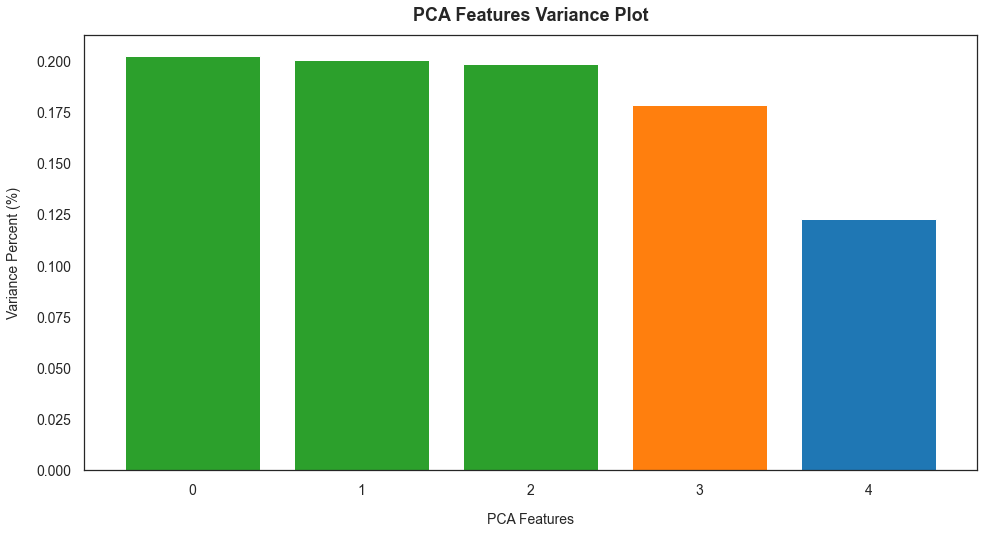

In [173]:
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(sf)
features = range(pca.n_components_)
plt.figure(figsize=(16,8))
bar_colors = ['tab:green', 'tab:green', 'tab:green', 'tab:orange', 'tab:blue']
plt.bar(features, pca.explained_variance_ratio_, color = bar_colors)
plt.title('PCA Features Variance Plot', y = 1.02,  fontsize=18, fontweight = 'bold')
plt.xlabel('PCA Features', labelpad = 15,  fontsize=14)
plt.ylabel('Variance Percent (%)', labelpad = 15,  fontsize=14)
plt.xticks(features, fontsize=14)
plt.yticks(fontsize=14)

PCA_components = pd.DataFrame(principalComponents)


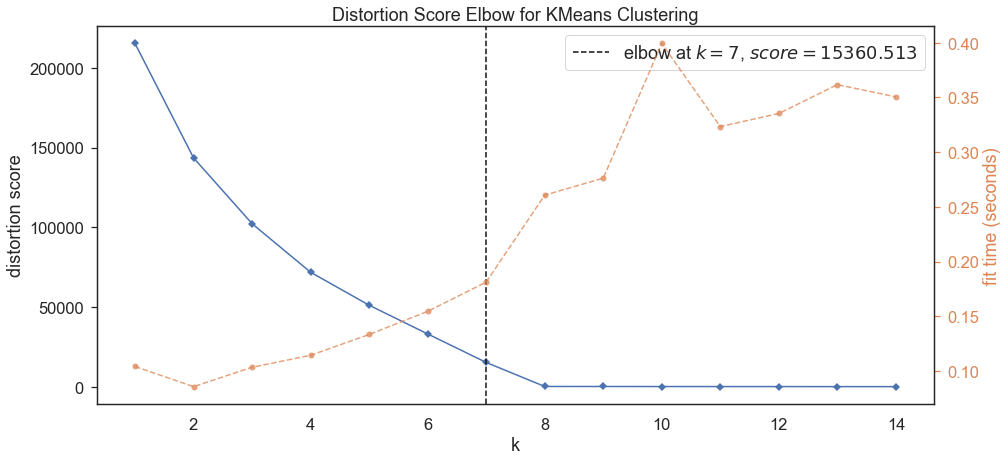

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [175]:
model = KMeans()
elbowplot = KElbowVisualizer(model, k=(1,15),size=(1080, 500))
elbowplot.fit(PCA_components.iloc[:,:3])
elbowplot.show()

In [177]:
kmeans_model = KMeans(n_clusters=7, init='k-means++',random_state=42)
kmeans_model.fit(PCA_components.iloc[:,:3])

print("silhouette_score is :",silhouette_score(PCA_components.iloc[:,:3], kmeans_model.labels_, metric='euclidean'))

silhouette_score is : 0.857538567860551


In [178]:
kmeans = model.predict(PCA_components.iloc[:,:3])
cluster_df = final_df_train.copy() 
cluster_df['cluster_gender'] = kmeans
cluster_df.head()

,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score,gender_F,gender_M,region_category_City,region_category_Town,...,feedback_No reason specified,feedback_Poor Customer Service,feedback_Poor Product Quality,feedback_Poor Website,feedback_Products always in Stock,feedback_Quality Customer Care,feedback_Reasonable Price,feedback_Too many ads,feedback_User Friendly Website,cluster_gender
0,17.0,300.63,53005.25,17.0,781.750000,2,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,16.0,306.34,12838.38,10.0,498.382015,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,13
2,14.0,516.16,21027.00,22.0,500.690000,5,1,0,0,1,...,0,0,0,1,0,0,0,0,0,12
3,11.0,53.27,25239.56,6.0,567.660000,5,0,1,1,0,...,0,0,0,1,0,0,0,0,0,7
4,20.0,113.13,24483.66,16.0,663.060000,5,1,0,1,0,...,0,0,0,1,0,0,0,0,0,3


In [179]:
avg_df = cluster_df.groupby(['cluster_gender'], as_index=False).mean()
avg_df

,cluster_gender,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score,gender_F,gender_M,region_category_City,...,complaint_status_Unsolved,feedback_No reason specified,feedback_Poor Customer Service,feedback_Poor Product Quality,feedback_Poor Website,feedback_Products always in Stock,feedback_Quality Customer Care,feedback_Reasonable Price,feedback_Too many ads,feedback_User Friendly Website
0,0,12.699402,264.320912,36931.664298,14.476939,756.138085,2.284548,1.0,0.0,0.156148,...,0.000000,0.115887,0.100653,0.096844,0.097933,0.120239,0.098477,0.134929,0.114255,0.120783
1,1,12.621345,340.253260,29653.638821,16.638225,690.974628,3.571150,0.0,1.0,0.000000,...,0.000000,0.176901,0.172515,0.159357,0.163255,0.038499,0.047758,0.040936,0.163255,0.037524
2,2,12.909201,249.024997,25539.875430,17.762909,651.612717,4.259338,0.0,1.0,0.439113,...,0.244458,0.196477,0.200729,0.206195,0.195870,0.000000,0.000000,0.000000,0.200729,0.000000
3,3,13.021597,259.512001,25441.404489,17.457255,658.468521,4.253500,1.0,0.0,0.458147,...,0.248734,0.207030,0.190944,0.198094,0.202562,0.000000,0.000000,0.000000,0.201370,0.000000
4,4,12.426167,355.428912,27825.839817,17.000126,687.743914,3.769640,1.0,0.0,0.777318,...,0.259894,0.180154,0.180154,0.183698,0.180154,0.020673,0.021855,0.023036,0.190195,0.020083
5,5,12.967159,250.171463,25623.932009,17.098977,648.980910,4.336572,0.0,1.0,0.579091,...,0.000000,0.211426,0.195880,0.210260,0.190051,0.000000,0.000000,0.000000,0.192382,0.000000
6,6,12.423956,349.762286,28849.663063,16.638228,690.751506,3.657736,1.0,0.0,0.341214,...,0.000000,0.171001,0.178618,0.175992,0.173628,0.033622,0.031784,0.034410,0.172051,0.028894
7,7,12.530753,345.905804,28448.333011,16.732333,687.751804,3.698948,0.0,1.0,0.351767,...,0.255463,0.175344,0.179121,0.178042,0.179390,0.025357,0.030753,0.031562,0.170219,0.030213
8,8,12.915681,252.150648,24976.911089,17.541936,656.656732,4.280861,1.0,0.0,0.441310,...,0.000000,0.197756,0.191386,0.217167,0.195632,0.000000,0.000000,0.000000,0.198059,0.000000
9,9,12.843888,254.005801,36783.600688,14.433343,745.204292,2.326542,0.0,1.0,0.138216,...,0.259361,0.112335,0.112885,0.105727,0.106278,0.112335,0.111233,0.120595,0.112885,0.105727


In [133]:
col_names_test = ['days_since_last_login', 'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days',
            'points_in_wallet', 'gender_F', 'gender_M', 'region_category_City',
            'region_category_Town', 'region_category_Village', 'membership_category_Basic Membership',
            'membership_category_Gold Membership', 'membership_category_No Membership', 'membership_category_Platinum Membership',
            'membership_category_Premium Membership', 'membership_category_Silver Membership', 'joined_through_referral_No',
            'joined_through_referral_Yes', 'preferred_offer_types_Credit/Debit Card Offers',
            'preferred_offer_types_Gift Vouchers/Coupons', 'preferred_offer_types_Without Offers',
            'medium_of_operation_Both', 'medium_of_operation_Desktop', 'medium_of_operation_Smartphone',
            'internet_option_Fiber_Optic', 'internet_option_Mobile_Data', 'internet_option_Wi-Fi', 'used_special_discount_No',
            'used_special_discount_Yes', 'offer_application_preference_No', 'offer_application_preference_Yes',
            'past_complaint_No', 'past_complaint_Yes', 'complaint_status_No Information Available',
            'complaint_status_Not Applicable', 'complaint_status_Solved', 'complaint_status_Solved in Follow-up',
            'complaint_status_Unsolved', 'feedback_No reason specified', 'feedback_Poor Customer Service',
            'feedback_Poor Product Quality', 'feedback_Poor Website', 'feedback_Products always in Stock',
            'feedback_Quality Customer Care', 'feedback_Quality Customer Care', 'feedback_Reasonable Price',
            'feedback_Too many ads', 'feedback_User Friendly Website']
sd_test=StandardScaler()
features_test = final_df_test[col_names_test]
scaler_test = sd_test.fit(features_test.values)
features_test = scaler_test.transform(features_test.values)
scaled_features_test = pd.DataFrame(features_test, columns = col_names_test)
scaled_features_test.head()

,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,gender_F,gender_M,region_category_City,region_category_Town,region_category_Village,...,feedback_No reason specified,feedback_Poor Customer Service,feedback_Poor Product Quality,feedback_Poor Website,feedback_Products always in Stock,feedback_Quality Customer Care,feedback_Quality Customer Care,feedback_Reasonable Price,feedback_Too many ads,feedback_User Friendly Website
0,-0.122036,0.272507,0.584567,-1.153600,0.240852,0.995142,-0.995142,-0.71931,-1.064692,2.613388,...,-0.455527,-0.454482,2.214424,-0.445691,-0.201608,-0.198486,-0.198486,-0.202952,-0.453758,-0.189287
1,-0.306024,-0.764249,-1.008532,-0.911572,0.197558,-1.004882,1.004882,-0.71931,-1.064692,2.613388,...,-0.455527,-0.454482,-0.451585,2.243709,-0.201608,-0.198486,-0.198486,-0.202952,-0.453758,-0.189287
2,0.981889,-0.235964,-1.313605,0.540593,0.129992,0.995142,-0.995142,-0.71931,0.939239,-0.382645,...,2.195260,-0.454482,-0.451585,-0.445691,-0.201608,-0.198486,-0.198486,-0.202952,-0.453758,-0.189287
3,-0.306024,-0.744107,0.384033,-0.669545,0.302447,-1.004882,1.004882,-0.71931,0.939239,-0.382645,...,-0.455527,-0.454482,-0.451585,-0.445691,-0.201608,-0.198486,-0.198486,-0.202952,2.203816,-0.189287
4,-1.225961,0.164267,0.582231,-1.032586,-2.163137,0.995142,-0.995142,-0.71931,0.939239,-0.382645,...,-0.455527,-0.454482,-0.451585,2.243709,-0.201608,-0.198486,-0.198486,-0.202952,-0.453758,-0.189287


In [180]:
sf_test = scaled_features_test[['gender_F', 'gender_M', 'region_category_City','region_category_Town',
                      'region_category_Village','past_complaint_No', 'past_complaint_Yes','joined_through_referral_No',
                      'joined_through_referral_Yes']]

sf_test.head()

,gender_F,gender_M,region_category_City,region_category_Town,region_category_Village,past_complaint_No,past_complaint_Yes,joined_through_referral_No,joined_through_referral_Yes
0,0.995142,-0.995142,-0.71931,-1.064692,2.613388,1.000954,-1.000954,1.182676,-1.182676
1,-1.004882,1.004882,-0.71931,-1.064692,2.613388,1.000954,-1.000954,1.182676,-1.182676
2,0.995142,-0.995142,-0.71931,0.939239,-0.382645,-0.999047,0.999047,1.182676,-1.182676
3,-1.004882,1.004882,-0.71931,0.939239,-0.382645,-0.999047,0.999047,-0.845540,0.845540
4,0.995142,-0.995142,-0.71931,0.939239,-0.382645,-0.999047,0.999047,-0.845540,0.845540


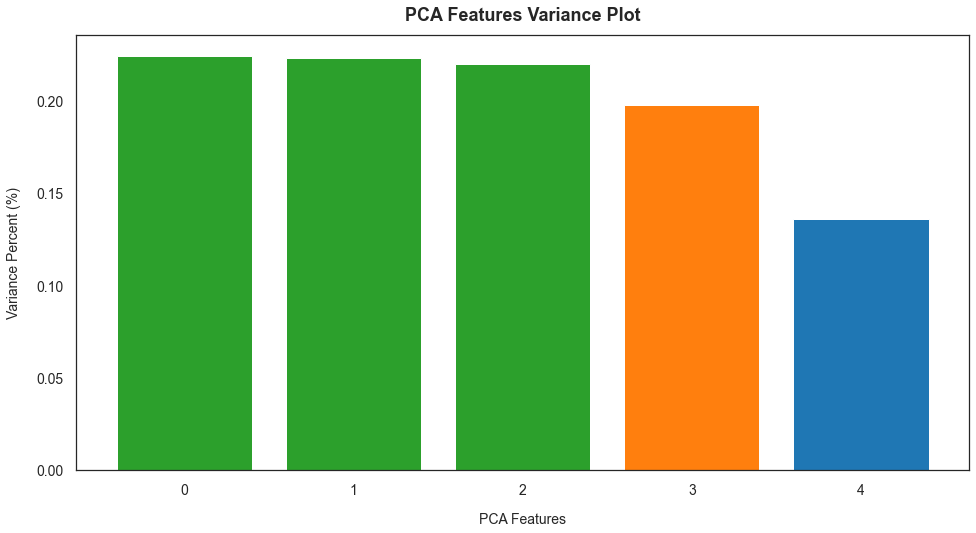

In [181]:
pca_test = PCA(n_components=5)
principalComponents_test = pca_test.fit_transform(sf_test)
features_test = range(pca_test.n_components_)
plt.figure(figsize=(16,8))
bar_colors = ['tab:green', 'tab:green', 'tab:green', 'tab:orange', 'tab:blue']
plt.bar(features_test, pca_test.explained_variance_ratio_, color = bar_colors)
plt.title('PCA Features Variance Plot', y = 1.02,  fontsize=18, fontweight = 'bold')
plt.xlabel('PCA Features', labelpad = 15,  fontsize=14)
plt.ylabel('Variance Percent (%)', labelpad = 15,  fontsize=14)
plt.xticks(features, fontsize=14)
plt.yticks(fontsize=14)

PCA_components_test = pd.DataFrame(principalComponents_test)

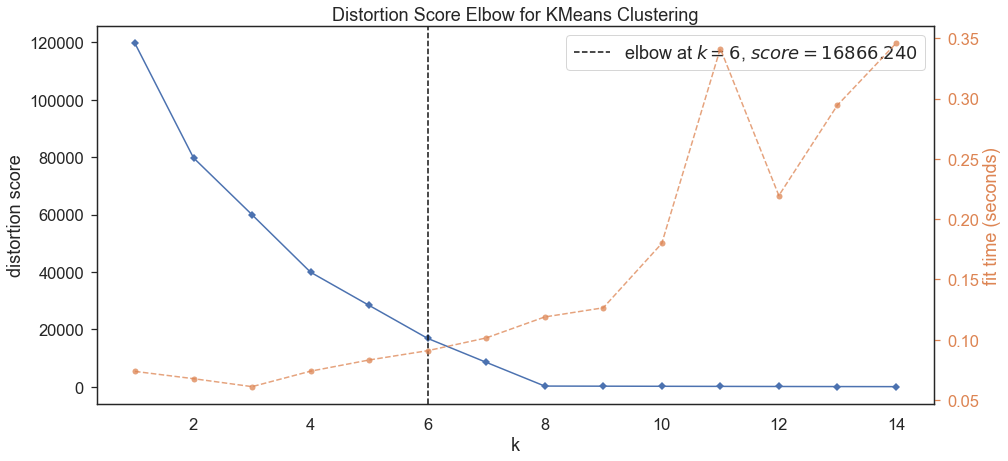

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [182]:
model = KMeans()
elbowplot = KElbowVisualizer(model, k=(1,15),size=(1080, 500))
elbowplot.fit(PCA_components_test.iloc[:,:3])
elbowplot.show()

In [183]:
model_test = KMeans(n_clusters=6, init='k-means++',random_state=42)
model_test.fit(PCA_components_test.iloc[:,:3])
print("silhouette_score is :",silhouette_score(PCA_components_test.iloc[:,:3], model_test.labels_, metric='euclidean'))

silhouette_score is : 0.7594925857437258


In [184]:
kmeans_test = model_test.predict(PCA_components_test.iloc[:,:3])
cluster_df_test = final_df_test.copy() 
cluster_df_test['cluster_gender'] = kmeans_test
cluster_df_test.head()

,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,gender_F,gender_M,region_category_City,region_category_Town,region_category_Village,...,feedback_No reason specified,feedback_Poor Customer Service,feedback_Poor Product Quality,feedback_Poor Website,feedback_Products always in Stock,feedback_Quality Customer Care,feedback_Reasonable Price,feedback_Too many ads,feedback_User Friendly Website,cluster_gender
0,12,386.26,40721.44,7.0,733.830000,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,5
1,11,37.80,9644.40,9.0,726.000000,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,5
2,18,215.36,3693.25,21.0,713.780000,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,11,44.57,36809.56,11.0,744.970000,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,2
4,6,349.88,40675.86,8.0,299.048351,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,3


In [185]:
# creating new datasets based on each cluster (subset datasets)

grouped = cluster_df.groupby('cluster_gender')
 
df_grouped_0 = grouped.get_group(0)
df_grouped_0 = pd.DataFrame(df_grouped_0)

df_grouped_1 = grouped.get_group(1)
df_grouped_1 = pd.DataFrame(df_grouped_1)

df_grouped_2 = grouped.get_group(2)
df_grouped_2 = pd.DataFrame(df_grouped_2)

df_grouped_3 = grouped.get_group(3)
df_grouped_3 = pd.DataFrame(df_grouped_3)

df_grouped_4 = grouped.get_group(4)
df_grouped_4 = pd.DataFrame(df_grouped_4)

df_grouped_5 = grouped.get_group(5)
df_grouped_5 = pd.DataFrame(df_grouped_5)


In [186]:
# FOR CLUSTER 4
X_1 = df_grouped_4.drop(['churn_risk_score'],axis=1).values
Y_1 = df_grouped_4['churn_risk_score'].values

oversample = SMOTE()
X_ov_1,Y_ov_1 = oversample.fit_resample(X_1,Y_1)

In [187]:
scaler = RobustScaler()
X_ov_1 = scaler.fit_transform(X_ov_1)
X_test_1 = cluster_df_test.values
X_test_1 = scaler.transform(X_test_1)

In [188]:
x_train3,x_test3,y_train3,y_test3 = train_test_split(X_ov_1,Y_ov_1,train_size=0.7)
print(x_train3.shape,y_train3.shape)
print(x_test3.shape,y_test3.shape)

(1882, 48) (1882,)
(808, 48) (808,)


In [189]:
## RANDOM FOREST CLASSIFIER

rf3 = RandomForestClassifier(n_estimators=1000,max_depth=25)
rf3.fit(x_train3,y_train3)
y_pred3 = rf3.predict(x_test3)
print(classification_report(y_true=y_test3,y_pred=y_pred3))
print(f1_score(y_true=y_test3,y_pred=y_pred3,average='macro'))

              precision    recall  f1-score   support

           1       0.98      0.99      0.99       167
           2       0.99      0.98      0.99       162
           3       0.90      0.92      0.91       159
           4       0.76      0.51      0.61       155
           5       0.72      0.92      0.81       165

    accuracy                           0.87       808
   macro avg       0.87      0.87      0.86       808
weighted avg       0.87      0.87      0.86       808

0.8608877688899053


In [190]:
## MLP Classifier with 3 hidden layers of decreasing nodes

from sklearn.neural_network import MLPClassifier
mlp3 = MLPClassifier(hidden_layer_sizes=(120,95,70))
mlp3.fit(x_train3,y_train3)
y_pred3 = mlp3.predict(x_test3)
print(classification_report(y_true=y_test3,y_pred=y_pred3))
print(f1_score(y_true=y_test3,y_pred=y_pred3,average='macro'))

              precision    recall  f1-score   support

           1       0.99      1.00      0.99       167
           2       1.00      0.99      1.00       162
           3       0.85      0.74      0.79       159
           4       0.50      0.58      0.54       155
           5       0.72      0.69      0.71       165

    accuracy                           0.80       808
   macro avg       0.81      0.80      0.80       808
weighted avg       0.81      0.80      0.81       808

0.8048989182391431


In [191]:
## Gradient Boosting Classifier

gb3 = GradientBoostingClassifier(n_estimators=1000,max_depth=25,min_samples_leaf = 4, min_samples_split= 5)
gb3.fit(x_train3,y_train3)
y_pred3 = gb3.predict(x_test3)
print(classification_report(y_true=y_test3,y_pred=y_pred3))
print(f1_score(y_true=y_test3,y_pred=y_pred3,average='macro'))

              precision    recall  f1-score   support

           1       0.98      0.95      0.96       167
           2       0.95      0.98      0.96       162
           3       0.90      0.91      0.90       159
           4       0.65      0.60      0.63       155
           5       0.74      0.79      0.76       165

    accuracy                           0.85       808
   macro avg       0.84      0.85      0.84       808
weighted avg       0.85      0.85      0.85       808

0.8442892595351064


In [192]:
# Training
y_pred2tr3 = rf3.predict(x_train3)
y_pred3tr3 = mlp3.predict(x_train3)
y_pred4tr3 = gb3.predict(x_train3)

# Testing
y_pred2_3 = rf3.predict(x_test3)
y_pred3_3 = mlp3.predict(x_test3)
y_pred4_3 = gb3.predict(x_test3)

In [193]:
# Final Comparison Table - Cluster 4

results3 = pd.DataFrame({'Prediction Model':['Random Forest','MLP','Gradient Boosting'],
                    'Training Accuracy (%)':[accuracy(y_train3,y_pred2tr3), accuracy(y_train3,y_pred3tr3), accuracy(y_train3,y_pred4tr3)],
                    'Testing Accuracy (%)':[accuracy(y_test3,y_pred2_3), accuracy(y_test3,y_pred3_3), accuracy(y_test3,y_pred4_3)],
                    'Testing f1-score (%)':[f1(y_test3,y_pred2_3), f1(y_test3,y_pred3_3), f1(y_test3,y_pred4_3)]})
results3.style.highlight_max(color = 'lightgreen', subset = 'Testing Accuracy (%)')


,Prediction Model,Training Accuracy (%),Testing Accuracy (%),Testing f1-score (%)
0,Random Forest,1.000000,0.870050,0.860888
1,MLP,1.000000,0.804455,0.804899
2,Gradient Boosting,1.000000,0.847772,0.844289


#### Plots

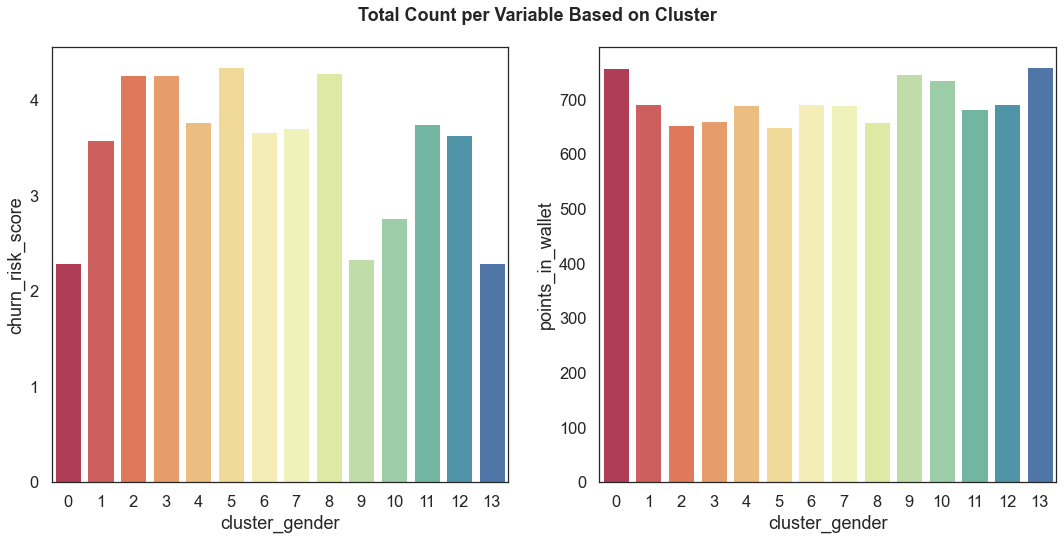

In [269]:
sns.set_style('white')
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
sns.set(font_scale=1.5)
sns.barplot(x='cluster_gender',y='churn_risk_score',data=avg_df ,ax=ax[0], palette = 'Spectral')
sns.barplot(x='cluster_gender',y='points_in_wallet',data=avg_df, ax=ax[1], palette = 'Spectral')
plt.suptitle('Total Count per Variable Based on Cluster', y = 0.95,  fontsize=18, fontweight = 'bold')
fig.tight_layout()
plt.show()

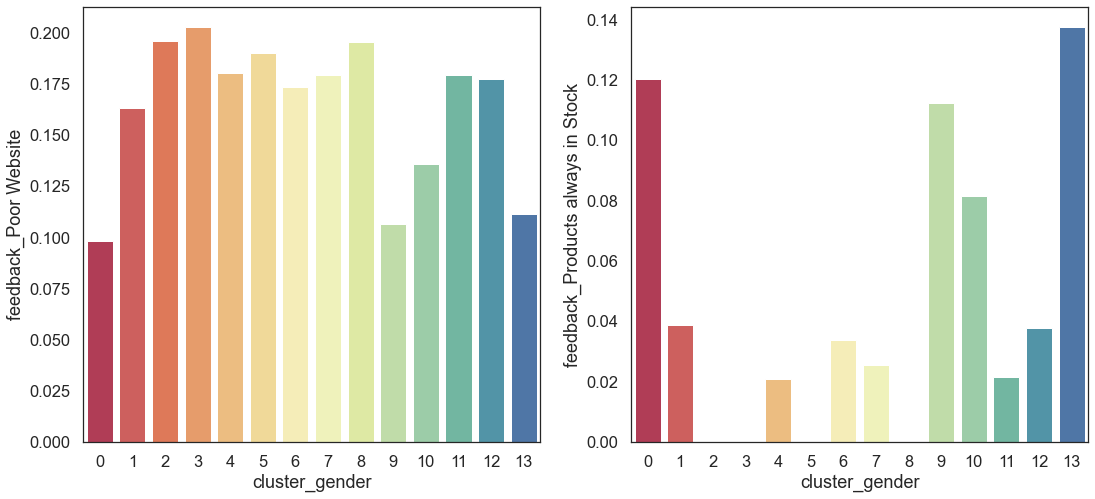

In [264]:
sns.set_style('white')
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
sns.set(font_scale=1.5)
sns.barplot(x='cluster_gender',y='feedback_Poor Website',data=avg_df, ax=ax[0], palette = 'Spectral')
sns.barplot(x='cluster_gender',y='feedback_Products always in Stock',data=avg_df, ax=ax[1], palette = 'Spectral')
fig.tight_layout()
plt.show()

## --- Churn Prediction with Segmentation Method # 2 -  DBSCAN --- 

In [ ]:
#final_df_train.drop(['cluster_gender'], axis=1, inplace=True)

In [194]:
dbscan = DBSCAN(eps=0.8, min_samples=9)
db_clusters = dbscan.fit_predict(PCA_components.iloc[:,:3])
print(db_clusters)
db_cluster_df = final_df_train.copy()
db_cluster_df['dbscan_clusters'] = db_clusters
db_cluster_df.head()

[0 1 2 ... 2 6 6]


,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score,gender_F,gender_M,region_category_City,region_category_Town,...,feedback_No reason specified,feedback_Poor Customer Service,feedback_Poor Product Quality,feedback_Poor Website,feedback_Products always in Stock,feedback_Quality Customer Care,feedback_Reasonable Price,feedback_Too many ads,feedback_User Friendly Website,dbscan_clusters
0,17.0,300.63,53005.25,17.0,781.750000,2,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,16.0,306.34,12838.38,10.0,498.382015,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,1
2,14.0,516.16,21027.00,22.0,500.690000,5,1,0,0,1,...,0,0,0,1,0,0,0,0,0,2
3,11.0,53.27,25239.56,6.0,567.660000,5,0,1,1,0,...,0,0,0,1,0,0,0,0,0,3
4,20.0,113.13,24483.66,16.0,663.060000,5,1,0,1,0,...,0,0,0,1,0,0,0,0,0,1


In [195]:
avg_df_db = db_cluster_df.groupby(['dbscan_clusters'], as_index=False).mean()
avg_df_db

,dbscan_clusters,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score,gender_F,gender_M,region_category_City,...,complaint_status_Unsolved,feedback_No reason specified,feedback_Poor Customer Service,feedback_Poor Product Quality,feedback_Poor Website,feedback_Products always in Stock,feedback_Quality Customer Care,feedback_Reasonable Price,feedback_Too many ads,feedback_User Friendly Website
0,0,12.838267,256.506820,29255.944467,16.444864,692.264663,3.566310,1.0,0.0,0.339241,...,0.000000,0.168452,0.158909,0.174099,0.160662,0.043038,0.035248,0.048296,0.168062,0.043233
1,1,13.018619,257.055456,29970.158534,16.382878,692.960610,3.566718,1.0,0.0,0.349302,...,0.253685,0.169511,0.156905,0.167572,0.170675,0.047905,0.038014,0.037044,0.168735,0.043638
2,2,12.509610,355.473446,28530.428769,16.961294,689.137399,3.691169,1.0,0.0,0.341818,...,0.251948,0.167792,0.183117,0.170649,0.178442,0.030130,0.032987,0.029870,0.177922,0.029091
3,3,12.530753,345.905804,28448.333011,16.732333,687.751804,3.698948,0.0,1.0,0.351767,...,0.255463,0.175344,0.179121,0.178042,0.179390,0.025357,0.030753,0.031562,0.170219,0.030213
4,4,12.885986,250.795430,29536.470667,16.579411,684.879952,3.572323,0.0,1.0,0.332159,...,0.249755,0.166569,0.169505,0.170483,0.164024,0.039930,0.039538,0.042866,0.169505,0.037581
5,5,12.423956,349.762286,28849.663063,16.638228,690.751506,3.657736,1.0,0.0,0.341214,...,0.000000,0.171001,0.178618,0.175992,0.173628,0.033622,0.031784,0.034410,0.172051,0.028894
6,6,12.838734,252.738936,30320.716517,16.057214,692.402308,3.534502,0.0,1.0,0.344834,...,0.000000,0.166603,0.159550,0.167747,0.162409,0.041555,0.043652,0.044605,0.165841,0.048037
7,7,12.479445,341.390899,28827.510919,16.717043,686.743013,3.649385,0.0,1.0,0.352710,...,0.000000,0.173082,0.177795,0.171773,0.170725,0.030636,0.039277,0.033255,0.171773,0.031684


In [196]:
dbscan_test = DBSCAN(eps=0.8, min_samples=9)
db_clusters_test = dbscan_test.fit_predict(PCA_components_test.iloc[:,:3])
print(db_clusters_test)
db_cluster_df_test = final_df_test.copy()
db_cluster_df_test['dbscan_clusters'] = db_clusters_test
db_cluster_df_test.head()

[0 1 2 ... 7 6 3]


,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,gender_F,gender_M,region_category_City,region_category_Town,region_category_Village,...,feedback_No reason specified,feedback_Poor Customer Service,feedback_Poor Product Quality,feedback_Poor Website,feedback_Products always in Stock,feedback_Quality Customer Care,feedback_Reasonable Price,feedback_Too many ads,feedback_User Friendly Website,dbscan_clusters
0,12,386.26,40721.44,7.0,733.830000,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,11,37.80,9644.40,9.0,726.000000,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,1
2,18,215.36,3693.25,21.0,713.780000,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,2
3,11,44.57,36809.56,11.0,744.970000,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,3
4,6,349.88,40675.86,8.0,299.048351,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,4


In [197]:
# creating new datasets based on each cluster (subset datasets)

grouped3 = db_cluster_df.groupby('dbscan_clusters')
 
df_grouped_00 = grouped.get_group(0)
df_grouped_00 = pd.DataFrame(df_grouped_00)

df_grouped_11 = grouped.get_group(1)
df_grouped_11 = pd.DataFrame(df_grouped_11)

df_grouped_22 = grouped.get_group(2)
df_grouped_22 = pd.DataFrame(df_grouped_22)

df_grouped_33 = grouped.get_group(3)
df_grouped_33 = pd.DataFrame(df_grouped_33)

df_grouped_44 = grouped.get_group(4)
df_grouped_44 = pd.DataFrame(df_grouped_44)

df_grouped_55 = grouped.get_group(5)
df_grouped_55 = pd.DataFrame(df_grouped_55)

df_grouped_10 = grouped.get_group(10)
df_grouped_10 = pd.DataFrame(df_grouped_10)


In [198]:
X_00 = df_grouped_00.drop(['churn_risk_score'],axis=1).values
Y_00 = df_grouped_00['churn_risk_score'].values

oversample = SMOTE()
X_ov_00,Y_ov_00 = oversample.fit_resample(X_00,Y_00)

In [199]:
scaler = RobustScaler()
X_ov_00 = scaler.fit_transform(X_ov_00)
X_test_00 = cluster_df_test.values
X_test_00 = scaler.transform(X_test_00)

In [200]:
x_train00,x_test00,y_train00,y_test00 = train_test_split(X_ov_00,Y_ov_00,train_size=0.7)
print(x_train00.shape,y_train00.shape)
print(x_test00.shape,y_test00.shape)

(2028, 48) (2028,)
(870, 48) (870,)


In [201]:
## RANDOM FOREST CLASSIFIER

rf00 = RandomForestClassifier(n_estimators=1000,max_depth=25)
rf00.fit(x_train00,y_train00)
y_pred00 = rf00.predict(x_test00)
print(classification_report(y_true=y_test00,y_pred=y_pred00))
print(f1_score(y_true=y_test00,y_pred=y_pred00,average='macro'))

              precision    recall  f1-score   support

           1       0.89      0.90      0.89       295
           2       0.89      0.87      0.88       269
           3       1.00      1.00      1.00       306

    accuracy                           0.93       870
   macro avg       0.92      0.92      0.92       870
weighted avg       0.93      0.93      0.93       870

0.9228911171244625


In [202]:
## MLP Classifier with 3 hidden layers of decreasing nodes

mlp00 = MLPClassifier(hidden_layer_sizes=(120,95,70))
mlp00.fit(x_train00,y_train00)
y_pred00 = mlp00.predict(x_test00)
print(classification_report(y_true=y_test00,y_pred=y_pred00))
print(f1_score(y_true=y_test00,y_pred=y_pred00,average='macro'))

              precision    recall  f1-score   support

           1       0.88      0.88      0.88       295
           2       0.87      0.87      0.87       269
           3       1.00      1.00      1.00       306

    accuracy                           0.92       870
   macro avg       0.92      0.92      0.92       870
weighted avg       0.92      0.92      0.92       870

0.9182791499066058


In [203]:
## Gradient Boosting Classifier

gb00 = GradientBoostingClassifier(n_estimators=1000,max_depth=25,min_samples_leaf = 4, min_samples_split= 5)
gb00.fit(x_train00,y_train00)
y_pred00 = gb00.predict(x_test00)
print(classification_report(y_true=y_test00,y_pred=y_pred00))
print(f1_score(y_true=y_test00,y_pred=y_pred00,average='macro'))

              precision    recall  f1-score   support

           1       0.90      0.91      0.90       295
           2       0.90      0.88      0.89       269
           3       1.00      1.00      1.00       306

    accuracy                           0.93       870
   macro avg       0.93      0.93      0.93       870
weighted avg       0.93      0.93      0.93       870

0.9324199473410378


In [204]:
# Training
y_pred2tr00 = rf00.predict(x_train00)
y_pred3tr00 = mlp00.predict(x_train00)
y_pred4tr00 = gb00.predict(x_train00)

# Testing
y_pred20 = rf00.predict(x_test00)
y_pred30 = mlp00.predict(x_test00)
y_pred40 = gb00.predict(x_test00)


In [205]:
# Final Comparison Table - Cluster 1 - DBSCAN

from sklearn.metrics import accuracy_score

results9 = pd.DataFrame({'Prediction Model':['Random Forest','MLP','Gradient Boosting'],
                    'Training Accuracy (%)':[accuracy(y_train00,y_pred2tr00), accuracy(y_train00,y_pred3tr00), accuracy(y_train00,y_pred4tr00)],
                    'Testing Accuracy (%)':[accuracy(y_test00,y_pred20), accuracy(y_test00,y_pred30), accuracy(y_test00,y_pred40)],
                    'Testing f1-Score (%)':[f1(y_test00,y_pred20), f1(y_test00,y_pred30), f1(y_test00,y_pred40)]}
                    )

results9.style.highlight_max(color = 'lightgreen', subset = 'Testing Accuracy (%)')

,Prediction Model,Training Accuracy (%),Testing Accuracy (%),Testing f1-Score (%)
0,Random Forest,1.000000,0.925287,0.922891
1,MLP,1.000000,0.920690,0.918279
2,Gradient Boosting,1.000000,0.934483,0.932420


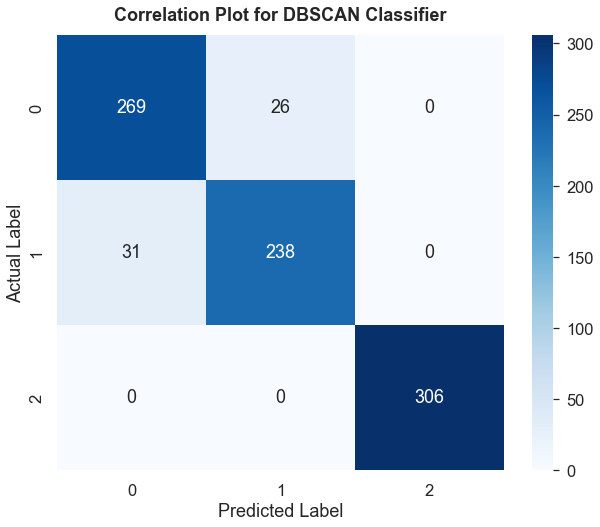

In [248]:
fig, ax = plt.subplots(figsize = (10,8))
sns.set_style('white')
cm = confusion_matrix(y_true=y_test00,y_pred=y_pred00)
sns.heatmap(cm, annot=True, ax = ax, cmap = 'Blues', fmt = 'g')
plt.title('Correlation Plot for DBSCAN Classifier', y = 1.02,  fontsize=18, fontweight = 'bold')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
plt.show()

#### Plots

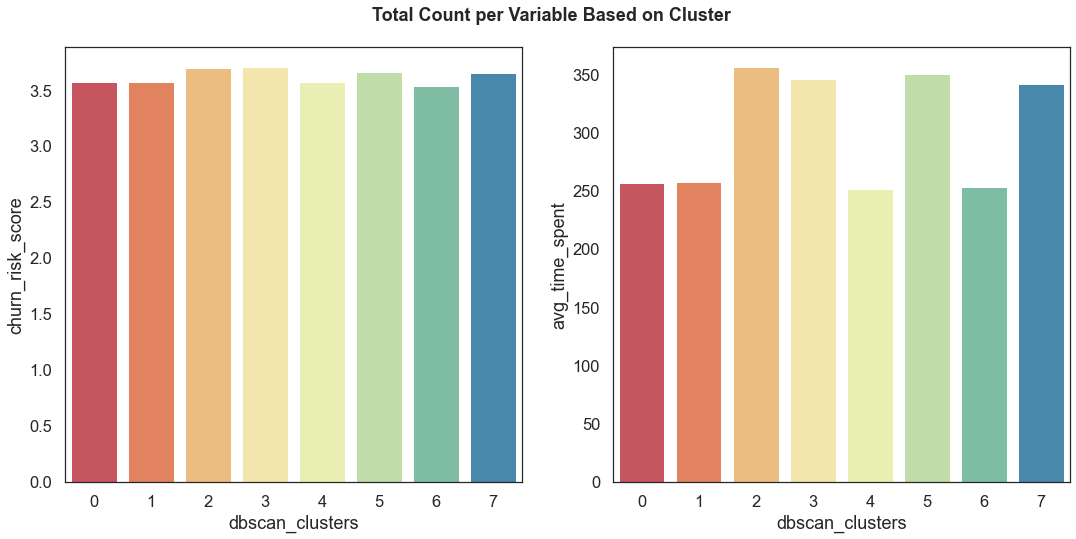

In [274]:
sns.set_style('white')
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
sns.set(font_scale=1.5)
sns.barplot(x='dbscan_clusters',y='churn_risk_score',data=avg_df_db ,ax=ax[0], palette = 'Spectral')
sns.barplot(x='dbscan_clusters',y='avg_time_spent',data=avg_df_db, ax=ax[1], palette = 'Spectral')
plt.suptitle('Total Count per Variable Based on Cluster', y = 0.95,  fontsize=18, fontweight = 'bold')
fig.tight_layout()
plt.show()

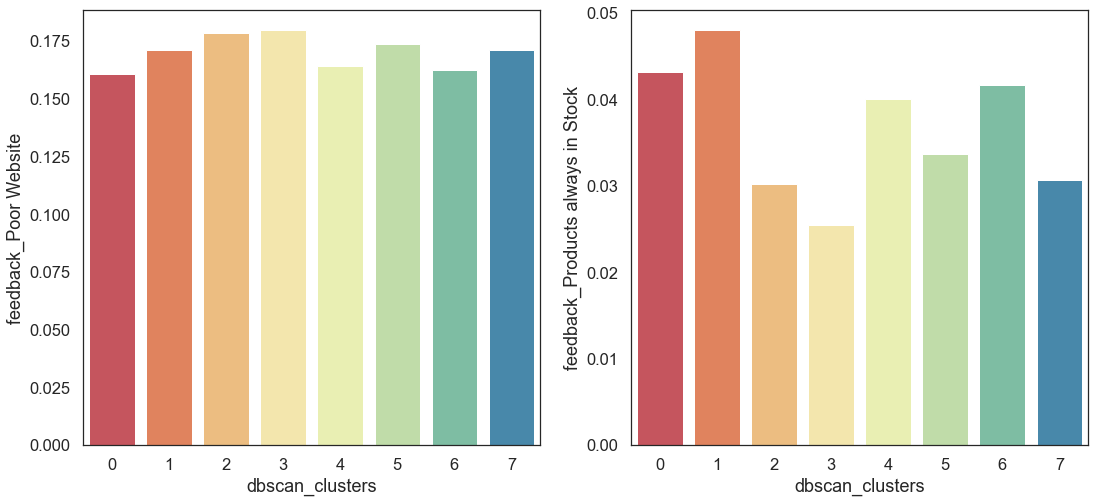

In [272]:
sns.set_style('white')
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
sns.set(font_scale=1.5)
sns.barplot(x='dbscan_clusters',y='feedback_Poor Website',data=avg_df_db ,ax=ax[0], palette = 'Spectral')
sns.barplot(x='dbscan_clusters',y='feedback_Products always in Stock',data=avg_df_db, ax=ax[1], palette = 'Spectral')
fig.tight_layout()
plt.show()

## --- Churn Prediction with Segmentation Method # 3 -  GMM --- 

In [206]:
cov_type =['full','tied','diag','spherical']
num_clusters=np.arange(1,12)
results_=pd.DataFrame(columns=['Covariance Type','# of Clusters','Silhouette Score','Davies Bouldin Score'])
for i in cov_type:
    for x in num_clusters:       
        gmm_cluster=GaussianMixture(n_components=x,covariance_type=i,random_state=5)
        clusters=gmm_cluster.fit_predict(PCA_components.iloc[:,:3])
        if len(np.unique(clusters))>=2:
            results_=results_.append({"Covariance Type":i,'# of Clusters':x,
                                      "Silhouette Score":metrics.silhouette_score(PCA_components.iloc[:,:3],clusters),
                                      'Davies Bouldin Score':metrics.davies_bouldin_score(PCA_components.iloc[:,:3],clusters)},ignore_index=True)
display(results_.sort_values(by=["Silhouette Score"], ascending=False)[:10])

/var/folders/1y/cgchrjwd7wlflct28tbjgcgw0000gn/T/ipykernel_54340/2097458208.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_=results_.append({"Covariance Type":i,'# of Clusters':x,
/var/folders/1y/cgchrjwd7wlflct28tbjgcgw0000gn/T/ipykernel_54340/2097458208.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_=results_.append({"Covariance Type":i,'# of Clusters':x,
/var/folders/1y/cgchrjwd7wlflct28tbjgcgw0000gn/T/ipykernel_54340/2097458208.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_=results_.append({"Covariance Type":i,'# of Clusters':x,
/var/folders/1y/cgchrjwd7wlflct28tbjgcgw0000gn/T/ipykernel_54340/2097458208.py:9: FutureWarning: The frame.append method is deprecated and will be removed

,Covariance Type,# of Clusters,Silhouette Score,Davies Bouldin Score
26,diag,8,0.958816,0.061612
6,full,8,0.958816,0.061612
36,spherical,8,0.958816,0.061612
16,tied,8,0.958816,0.061612
27,diag,9,0.884132,0.268688
7,full,9,0.883876,0.302182
17,tied,9,0.883876,0.302182
37,spherical,9,0.870645,0.228914
35,spherical,7,0.855598,0.438985
15,tied,7,0.855598,0.438985


In [226]:
gmm2=GaussianMixture(n_components=8, covariance_type='diag',max_iter=2000, random_state=5).fit(PCA_components.iloc[:,:2])
labels = gmm2.predict(PCA_components.iloc[:,:2])
gmm_cluster_df = final_df_train.copy()
gmm_cluster_df['gmm_clusters'] = labels
gmm_cluster_df.head()

,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score,gender_F,gender_M,region_category_City,region_category_Town,...,feedback_No reason specified,feedback_Poor Customer Service,feedback_Poor Product Quality,feedback_Poor Website,feedback_Products always in Stock,feedback_Quality Customer Care,feedback_Reasonable Price,feedback_Too many ads,feedback_User Friendly Website,gmm_clusters
0,17.0,300.63,53005.25,17.0,781.750000,2,1,0,0,0,...,0,0,0,0,1,0,0,0,0,6
1,16.0,306.34,12838.38,10.0,498.382015,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,4
2,14.0,516.16,21027.00,22.0,500.690000,5,1,0,0,1,...,0,0,0,1,0,0,0,0,0,5
3,11.0,53.27,25239.56,6.0,567.660000,5,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
4,20.0,113.13,24483.66,16.0,663.060000,5,1,0,1,0,...,0,0,0,1,0,0,0,0,0,4


In [227]:
avg_df_gmm = gmm_cluster_df.groupby(['gmm_clusters'], as_index=False).mean()
avg_df_gmm

,gmm_clusters,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score,gender_F,gender_M,region_category_City,...,complaint_status_Unsolved,feedback_No reason specified,feedback_Poor Customer Service,feedback_Poor Product Quality,feedback_Poor Website,feedback_Products always in Stock,feedback_Quality Customer Care,feedback_Reasonable Price,feedback_Too many ads,feedback_User Friendly Website
0,0,12.530753,345.905804,28448.333011,16.732333,687.751804,3.698948,0.0,1.0,0.351767,...,0.255463,0.175344,0.179121,0.178042,0.179390,0.025357,0.030753,0.031562,0.170219,0.030213
1,1,12.885986,250.795430,29536.470667,16.579411,684.879952,3.572323,0.0,1.0,0.332159,...,0.249755,0.166569,0.169505,0.170483,0.164024,0.039930,0.039538,0.042866,0.169505,0.037581
2,2,12.479445,341.390899,28827.510919,16.717043,686.743013,3.649385,0.0,1.0,0.352710,...,0.000000,0.173082,0.177795,0.171773,0.170725,0.030636,0.039277,0.033255,0.171773,0.031684
3,3,12.838734,252.738936,30320.716517,16.057214,692.402308,3.534502,0.0,1.0,0.344834,...,0.000000,0.166603,0.159550,0.167747,0.162409,0.041555,0.043652,0.044605,0.165841,0.048037
4,4,13.018619,257.055456,29970.158534,16.382878,692.960610,3.566718,1.0,0.0,0.349302,...,0.253685,0.169511,0.156905,0.167572,0.170675,0.047905,0.038014,0.037044,0.168735,0.043638
5,5,12.509610,355.473446,28530.428769,16.961294,689.137399,3.691169,1.0,0.0,0.341818,...,0.251948,0.167792,0.183117,0.170649,0.178442,0.030130,0.032987,0.029870,0.177922,0.029091
6,6,12.838267,256.506820,29255.944467,16.444864,692.264663,3.566310,1.0,0.0,0.339241,...,0.000000,0.168452,0.158909,0.174099,0.160662,0.043038,0.035248,0.048296,0.168062,0.043233
7,7,12.423956,349.762286,28849.663063,16.638228,690.751506,3.657736,1.0,0.0,0.341214,...,0.000000,0.171001,0.178618,0.175992,0.173628,0.033622,0.031784,0.034410,0.172051,0.028894


In [209]:
cov_type=['full','tied','diag','spherical']
num_clusters=np.arange(1,12)
results_=pd.DataFrame(columns=['Covariance Type','# of Clusters','Silhouette Score','Davies Bouldin Score'])
for i in cov_type:
    for x in num_clusters:       
        gmm_cluster=GaussianMixture(n_components=x,covariance_type=i,random_state=5)
        clusters=gmm_cluster.fit_predict(PCA_components_test.iloc[:,:3])
        if len(np.unique(clusters))>=2:
            results_=results_.append({"Covariance type":i,'# of Clusters':x,
                                      "Silhouette Score":metrics.silhouette_score(PCA_components_test.iloc[:,:3],clusters),
                                      'Davies Bouldin Score':metrics.davies_bouldin_score(PCA_components_test.iloc[:,:3],clusters)},ignore_index=True)
display(results_.sort_values(by=["Silhouette Score"], ascending=False)[:10])

/var/folders/1y/cgchrjwd7wlflct28tbjgcgw0000gn/T/ipykernel_54340/581188502.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_=results_.append({"Covariance type":i,'# of Clusters':x,
/var/folders/1y/cgchrjwd7wlflct28tbjgcgw0000gn/T/ipykernel_54340/581188502.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_=results_.append({"Covariance type":i,'# of Clusters':x,
/var/folders/1y/cgchrjwd7wlflct28tbjgcgw0000gn/T/ipykernel_54340/581188502.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_=results_.append({"Covariance type":i,'# of Clusters':x,
/var/folders/1y/cgchrjwd7wlflct28tbjgcgw0000gn/T/ipykernel_54340/581188502.py:9: FutureWarning: The frame.append method is deprecated and will be removed fro

,Covariance Type,# of Clusters,Silhouette Score,Davies Bouldin Score,Covariance type
16,NaN,8,0.956388,0.081184,tied
6,NaN,8,0.956388,0.081184,full
26,NaN,8,0.956388,0.081184,diag
36,NaN,8,0.956388,0.081184,spherical
37,NaN,9,0.951251,0.09972,spherical
27,NaN,9,0.951251,0.09972,diag
7,NaN,9,0.951251,0.09972,full
17,NaN,9,0.951251,0.09972,tied
18,NaN,10,0.946325,0.114724,tied
28,NaN,10,0.946325,0.114724,diag


In [228]:
gmm3=GaussianMixture(n_components=8, covariance_type='tied',max_iter=2000, random_state=5).fit(PCA_components_test.iloc[:,:2])
labels_test = gmm3.predict(PCA_components_test.iloc[:,:2])
gmm_cluster_df_test = final_df_test.copy()
gmm_cluster_df_test['gmm_clusters'] = labels_test
gmm_cluster_df_test

,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,gender_F,gender_M,region_category_City,region_category_Town,region_category_Village,...,feedback_No reason specified,feedback_Poor Customer Service,feedback_Poor Product Quality,feedback_Poor Website,feedback_Products always in Stock,feedback_Quality Customer Care,feedback_Reasonable Price,feedback_Too many ads,feedback_User Friendly Website,gmm_clusters
0,12,386.26,40721.44,7.000000,733.830000,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,4
1,11,37.80,9644.40,9.000000,726.000000,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,6
2,18,215.36,3693.25,21.000000,713.780000,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
3,11,44.57,36809.56,11.000000,744.970000,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,3
4,6,349.88,40675.86,8.000000,299.048351,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19914,16,103.57,46279.35,18.000000,708.120000,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,6
19915,21,63.19,23466.26,22.292565,574.340000,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,7
19916,18,68.72,17903.75,24.000000,564.300000,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,2
19917,3,119.54,14057.09,22.000000,606.340000,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,7


In [229]:
# creating new datasets based on each cluster (subset datasets)
grouped3 = gmm_cluster_df.groupby('gmm_clusters')
 
df2_grouped_0 = grouped3.get_group(0)
df2_grouped_0 = pd.DataFrame(df2_grouped_0)

#df2_grouped_1 = grouped3.get_group(1)
#df2_grouped_1 = pd.DataFrame(df2_grouped_1)

df2_grouped_2 = grouped3.get_group(2)
df2_grouped_2 = pd.DataFrame(df2_grouped_2)

df2_grouped_3 = grouped3.get_group(3)
df2_grouped_3 = pd.DataFrame(df2_grouped_3)

df2_grouped_4 = grouped3.get_group(4)
df2_grouped_4 = pd.DataFrame(df2_grouped_4)

df2_grouped_5 = grouped3.get_group(5)
df2_grouped_5 = pd.DataFrame(df2_grouped_5)


In [230]:
X_10 = df2_grouped_5.drop(['churn_risk_score'],axis=1).values
Y_10 = df2_grouped_5['churn_risk_score'].values

oversample = SMOTE()
X_ov_10,Y_ov_10 = oversample.fit_resample(X_10,Y_10)

In [231]:
x_train5,x_test5,y_train5,y_test5 = train_test_split(X_ov_10,Y_ov_10,train_size=0.7)
print(x_train5.shape,y_train5.shape)
print(x_test5.shape,y_test5.shape)

(3975, 48) (3975,)
(1705, 48) (1705,)


In [232]:
## RANDOM FOREST CLASSIFIER

rf10 = RandomForestClassifier(n_estimators=1000,max_depth=25)
rf10.fit(x_train5,y_train5)
y_pred5 = rf10.predict(x_test5)
print(classification_report(y_true=y_test5,y_pred=y_pred5))
print(f1_score(y_true=y_test5,y_pred=y_pred5,average='macro'))

              precision    recall  f1-score   support

           1       0.95      0.96      0.96       368
           2       0.95      0.95      0.95       321
           3       0.86      0.95      0.91       321
           4       0.81      0.46      0.59       342
           5       0.71      0.94      0.81       353

    accuracy                           0.85      1705
   macro avg       0.86      0.85      0.84      1705
weighted avg       0.86      0.85      0.84      1705

0.8418155364793872


In [233]:
## MLP Classifier with 3 hidden layers of decreasing nodes

mlp10 = MLPClassifier(hidden_layer_sizes=(120, 95, 70))
mlp10.fit(x_train5,y_train5)
y_pred5 = mlp10.predict(x_test5)
print(classification_report(y_true=y_test5,y_pred=y_pred5))
print(f1_score(y_true=y_test5,y_pred=y_pred5,average='macro'))

              precision    recall  f1-score   support

           1       0.26      0.94      0.41       368
           2       0.23      0.03      0.06       321
           3       0.00      0.00      0.00       321
           4       0.31      0.27      0.29       342
           5       0.15      0.01      0.01       353

    accuracy                           0.27      1705
   macro avg       0.19      0.25      0.15      1705
weighted avg       0.19      0.27      0.16      1705

0.1536645954018959


/Users/smitpatel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/smitpatel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/smitpatel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [234]:
## Gradient Boosting Classifier

gb10 = GradientBoostingClassifier(n_estimators=1000,max_depth=25,min_samples_leaf = 4, min_samples_split= 5)
gb10.fit(x_train5,y_train5)
y_pred5 = gb10.predict(x_test5)
print(classification_report(y_true=y_test5,y_pred=y_pred5))
print(f1_score(y_true=y_test5,y_pred=y_pred5,average='macro'))

              precision    recall  f1-score   support

           1       0.95      0.96      0.95       368
           2       0.96      0.94      0.95       321
           3       0.88      0.89      0.89       321
           4       0.69      0.61      0.64       342
           5       0.75      0.83      0.79       353

    accuracy                           0.85      1705
   macro avg       0.84      0.85      0.84      1705
weighted avg       0.84      0.85      0.84      1705

0.8438939616304222


In [235]:
# Training
y_pred2tr10 = rf10.predict(x_train5)
y_pred3tr10 = mlp10.predict(x_train5)
y_pred4tr10 = gb10.predict(x_train5)

# Testing
y_pred2_10 = rf10.predict(x_test5)
y_pred3_10 = mlp10.predict(x_test5)
y_pred4_10 = gb10.predict(x_test5)

In [236]:
# Final Comparison Table - Cluster 0 

results10 = pd.DataFrame({'Prediction Model':['Random Forest','MLP','Gradient Boosting'],
                    'Training Accuracy (%)':[accuracy(y_train5,y_pred2tr10), accuracy(y_train5,y_pred3tr10), accuracy(y_train5,y_pred4tr10)],
                    'Testing Accuracy (%)':[accuracy(y_test5,y_pred2_10), accuracy(y_test5,y_pred3_10), accuracy(y_test5,y_pred4_10)],
                    'Testing f1-score (%)':[f1(y_test5,y_pred2_10), f1(y_test5,y_pred3_10), f1(y_test5,y_pred4_10)]}
                    )
results10.style.highlight_max(color = 'lightgreen', subset = 'Testing Accuracy (%)')


,Prediction Model,Training Accuracy (%),Testing Accuracy (%),Testing f1-score (%)
0,Random Forest,1.000000,0.851613,0.841816
1,MLP,0.239748,0.266276,0.153665
2,Gradient Boosting,1.000000,0.845161,0.843894


#### Plots

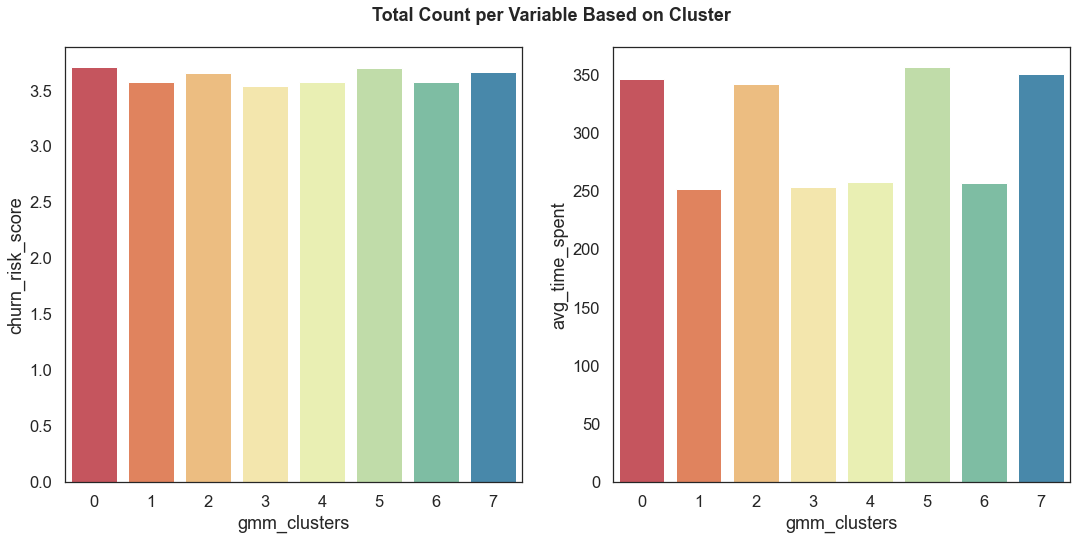

In [275]:
sns.set_style('white')
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
sns.set(font_scale=1.5)
sns.barplot(x='gmm_clusters',y='churn_risk_score',data=avg_df_gmm ,ax=ax[0], palette = 'Spectral')
sns.barplot(x='gmm_clusters',y='avg_time_spent',data=avg_df_gmm, ax=ax[1], palette = 'Spectral')
plt.suptitle('Total Count per Variable Based on Cluster', y = 0.95,  fontsize=18, fontweight = 'bold')
fig.tight_layout()
plt.show()

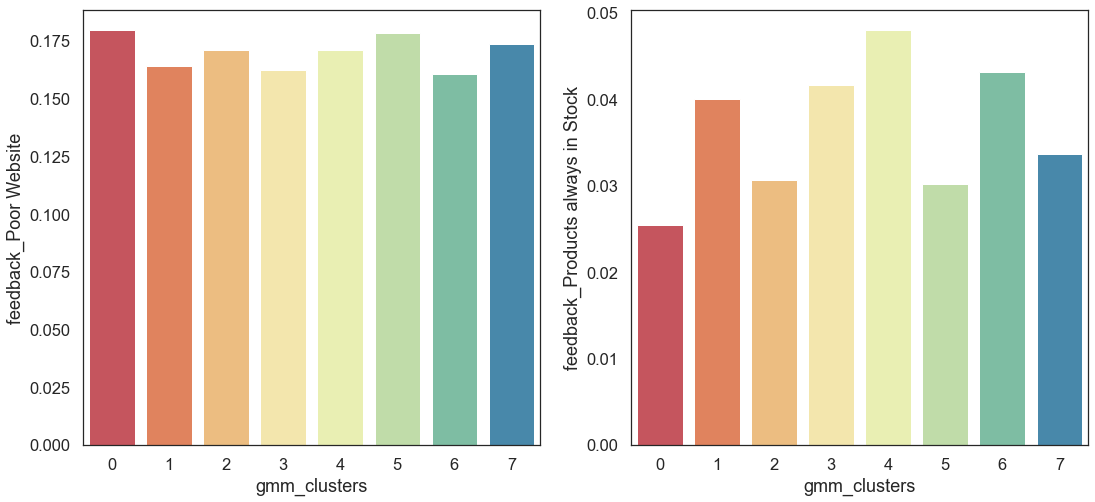

In [277]:
sns.set_style('white')
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
sns.set(font_scale=1.5)
sns.barplot(x='gmm_clusters',y='feedback_Poor Website',data=avg_df_gmm ,ax=ax[0], palette = 'Spectral')
sns.barplot(x='gmm_clusters',y='feedback_Products always in Stock',data=avg_df_gmm, ax=ax[1], palette = 'Spectral')
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
sns.set_style('white')
cm = confusion_matrix(y_true=y_test5,y_pred=y_pred5)
sns.heatmap(cm, annot=True, ax = ax, cmap = 'Blues', fmt = 'g')
plt.title('Correlation Plot for Gradient Boosting Classifier', y = 1.02,  fontsize=18, fontweight = 'bold')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
plt.show()